# Phần 1: Chọn mô hình

## 1.Import các thư viện cần thiết

In [55]:
# Cài đặt các thư viện cần thiết
!pip install pandas numpy matplotlib seaborn lifetimes scikit-learn xgboost tqdm

# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, accuracy_score, precision_score, recall_score,
    average_precision_score, make_scorer
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBRegressor, XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Cài đặt style mặc định cho seaborn và matplotlib
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.Tải lên các bảng dữ liệu

In [57]:
customers = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_customers_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_orders_dataset.csv")
items = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_order_items_dataset.csv")
payments = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_order_payments_dataset.csv")
reviews = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_order_reviews_dataset.csv")
category_translation =pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/product_category_name_translation.csv")
products = pd.read_csv("/content/drive/MyDrive/KLTN - Dataset/olist_products_dataset.csv")

In [58]:
# Kiểm tra kích thước và cột
print(customers.shape, orders.shape, items.shape, payments.shape, reviews.shape)

(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7)


### 2.1. Table orders

In [59]:
orders.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7/24/2018 20:41,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8/8/2018 8:38,8/8/2018 8:55,8/8/2018 13:50,8/17/2018 18:06,9/4/2018 0:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,11/18/2017 19:28,11/18/2017 19:45,11/22/2017 13:39,12/2/2017 0:28,12/15/2017 0:00


In [60]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


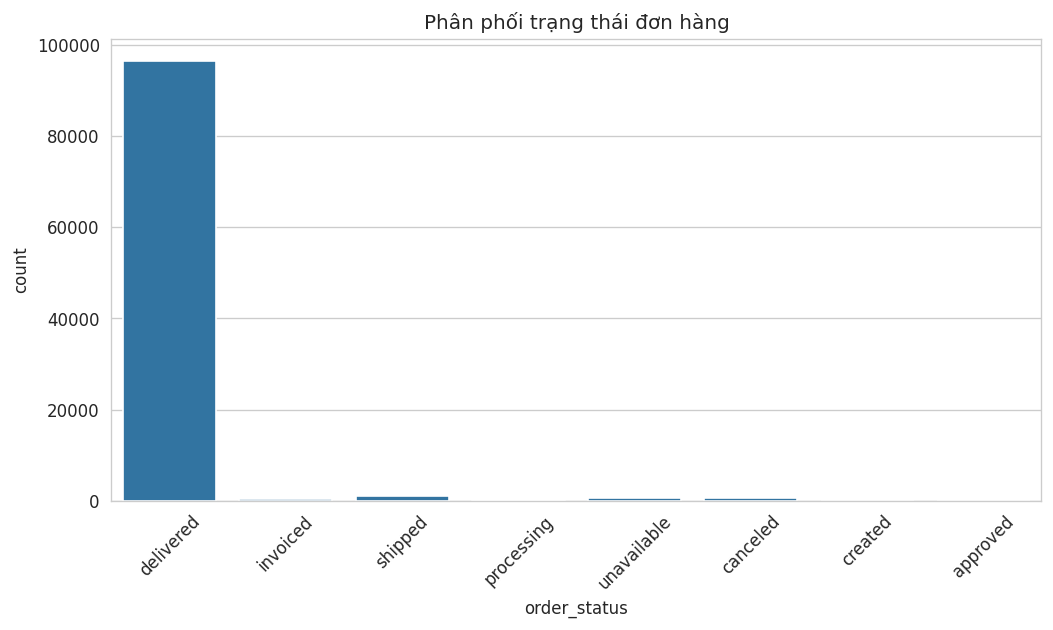

In [61]:
# Phân tích trạng thái đơn hàng
plt.figure(figsize=(10, 5))
sns.countplot(data=orders, x='order_status')
plt.title("Phân phối trạng thái đơn hàng")
plt.xticks(rotation=45)
plt.show()

In [62]:
status_summary = (
    orders['order_status']
    .value_counts()
    .to_frame('count')
)

status_summary['percent'] = (
    orders['order_status']
    .value_counts(normalize=True) * 100
).round(2)

print(status_summary)

              count  percent
order_status                
delivered     96478    97.02
shipped        1107     1.11
canceled        625     0.63
unavailable     609     0.61
invoiced        314     0.32
processing      301     0.30
created           5     0.01
approved          2     0.00


* Lưu ý: Ở phần phân tích phía sau, chỉ giữ lại các đơn hàng đã có trạng thái chuyển "delivered"

In [63]:
#Tạo funtion để tính tỉ lệ giá trị bị null trong các hàng
def calc_null_rate(df):
  newdf=df.isnull().sum().to_frame('null_count')
  newdf[['null_rate']]=newdf[['null_count']]/len(df)
  return newdf.sort_values(by=['null_rate'],ascending=False)

In [64]:
calc_null_rate(orders)

,null_count,null_rate
order_delivered_customer_date,2965,0.029817
order_delivered_carrier_date,1783,0.017930
order_approved_at,160,0.001609
order_id,0,0.000000
order_purchase_timestamp,0,0.000000
order_status,0,0.000000
customer_id,0,0.000000
order_estimated_delivery_date,0,0.000000


* Nhận xét: 3 cột đầu tiên có giá trị null nhưng phần phân tích phía dưới không dùng nên sẽ lược bỏ

### 2.2. Table items

In [65]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,9/19/2017 9:45,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,5/3/2017 11:05,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,1/18/2018 14:48,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,8/15/2018 10:10,12.99,12.79


In [66]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [67]:
calc_null_rate(items)

,null_count,null_rate
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [68]:
items['order_id'].nunique()

98666

Nhận xét: Vì mỗi đơn hàng có nhiều order_item khác nhau, nên số dòng tương ứng với số đơn hàng sẽ nhiều hơn số đơn riêng biệt (unique order id)

In [69]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


+ Nhận xét: Cột price và freight value không xuất hiện giá trị âm, phù hợp để thực hiện các phần tính toán phía dưới

In [70]:
# Kiểm tra tỷ lệ freight_value = 0
zero_freight = (items['freight_value'] == 0).sum()
total_rows = len(items)
print(f"Số dòng freight_value = 0: {zero_freight} ({zero_freight/total_rows*100:.2f}%)")

Số dòng freight_value = 0: 383 (0.34%)


+ Nhận xét: Có thể đây là những đơn hàng freeship nên giá trị vận chuyển = 0 là bình thường (Không loại bỏ)

### 2.3. Table customers

In [71]:
customers.head(4)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP


In [72]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [73]:
customers['customer_id'].nunique()

99441

In [74]:
customers['customer_unique_id'].nunique()

96096

* Nhận xét: Có 99,441 đơn hàng được gán cho 96,096 khách hàng thực tế
  → Tức là chỉ có khoảng 3,345 khách hàng đã mua từ 2 lần trở lên

In [75]:
repeat_customers = (
    customers.groupby('customer_unique_id')['customer_id']
    .nunique()
    .reset_index(name='order_count')
)

repeat_customers['is_repeat'] = repeat_customers['order_count'] > 1
repeat_customers['is_repeat'].value_counts(normalize=True) * 100

,proportion
is_repeat,
False,96.881244
True,3.118756


* Nhận xét: Nghĩa là khoảng 3.12% khách hàng thực đã mua nhiều hơn 1 lần và gần 97% khách hàng chỉ mua 1 lần duy nhất

In [76]:
# In ra số khách hàng ở mỗi tháng

orders_cust = orders.merge(customers, on='customer_id', how='left')

# Chuyển cột thời gian sang datetime
orders_cust['order_date'] = pd.to_datetime(orders_cust['order_purchase_timestamp'])

# Tạo cột tháng
orders_cust['order_month'] = orders_cust['order_date'].dt.to_period('M')

# Tính số khách hàng unique mỗi tháng (dựa trên customer_unique_id)
unique_users_by_month = (
    orders_cust.groupby('order_month')['customer_unique_id']
    .nunique()
    .reset_index()
    .rename(columns={'customer_unique_id': 'n_unique_users'})
)

# Chuyển order_month về dạng timestamp
unique_users_by_month['order_month'] = unique_users_by_month['order_month'].dt.to_timestamp()

print(unique_users_by_month.head(30))

   order_month  n_unique_users
0   2016-09-01               4
1   2016-10-01             321
2   2016-12-01               1
3   2017-01-01             765
4   2017-02-01            1755
5   2017-03-01            2642
6   2017-04-01            2372
7   2017-05-01            3625
8   2017-06-01            3180
9   2017-07-01            3947
10  2017-08-01            4246
11  2017-09-01            4212
12  2017-10-01            4561
13  2017-11-01            7430
14  2017-12-01            5603
15  2018-01-01            7166
16  2018-02-01            6569
17  2018-03-01            7115
18  2018-04-01            6882
19  2018-05-01            6814
20  2018-06-01            6128
21  2018-07-01            6230
22  2018-08-01            6460
23  2018-09-01              14
24  2018-10-01               4


* Nhận xét: Mặc dù Dataset từ 9/2016 - 10/2018, tuy nhiên bị thiếu dữ liệu của tháng 11/2016, đồng thời số khách hàng của tháng 9,10,12 năm 2016 và tháng 9,10 của năm 2018 rất nhỏ
  * Vì thế, bài phân tích chỉ tập trung vào khoảng 1/2017 đến 6/2018

## 3.Gộp bảng và lọc điều kiện

In [77]:
# Giữ đơn đã giao thành công (order_status là delivered)
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

# Tính giá trị đơn hàng = price + freight_value
items['order_value'] = items['price'] + items['freight_value']
order_val = items.groupby('order_id', as_index=False)['order_value'].sum()

# Merge bảng giao dịch
trans = (
    orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
#  .dropna()
#  .drop_duplicates()
)
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')

# Chỉ giữ lại dữ liệu từ 01/01/2017 trở đi
trans = trans[trans['order_date'] >= '2017-01-01']
print("Tổng số giao dịch:", len(trans))
trans.head(3)


Tổng số giao dịch: 96211


,order_id,customer_unique_id,order_date,order_value,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:00,38.71,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:00,141.46,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:00,179.12,GO


In [78]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96211 entries, 0 to 96477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            96211 non-null  object        
 1   customer_unique_id  96211 non-null  object        
 2   order_date          96211 non-null  datetime64[ns]
 3   order_value         96211 non-null  float64       
 4   customer_state      96211 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.4+ MB


In [79]:
calc_null_rate(trans)

,null_count,null_rate
order_id,0,0.0
customer_unique_id,0,0.0
order_date,0,0.0
order_value,0,0.0
customer_state,0,0.0


## 4.EDA (phân phối & đặc điểm dữ liệu)

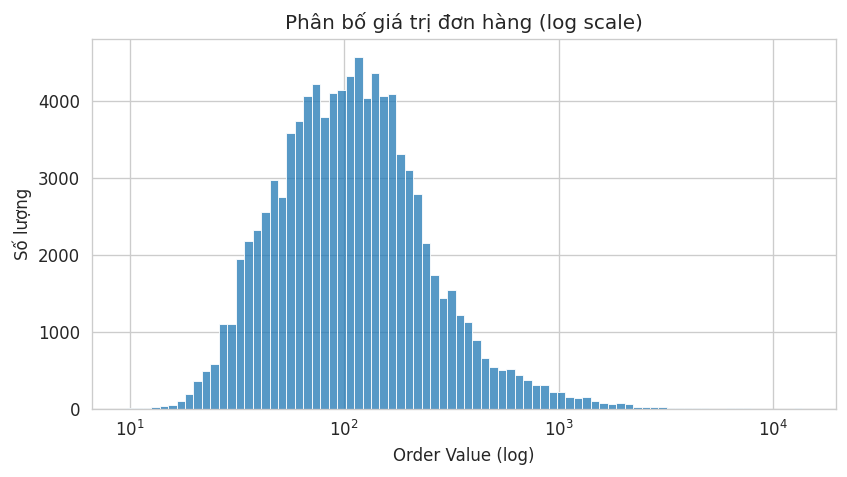

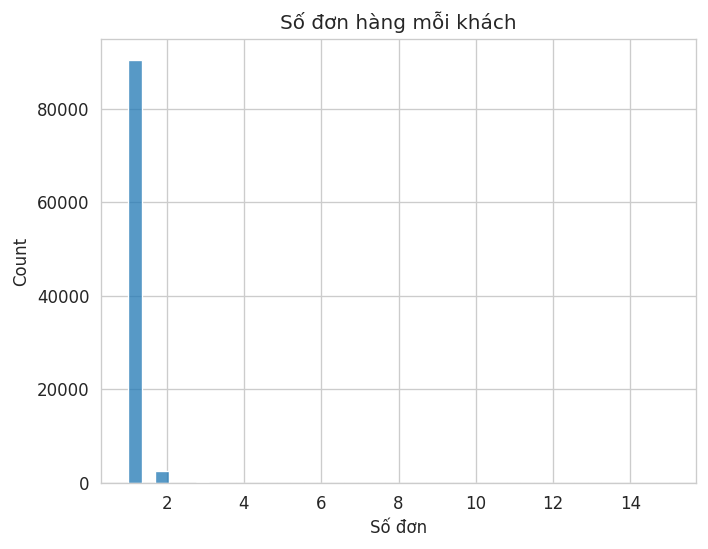

Tổng số khách: 93104
Số khách chỉ mua 1 lần: 90315
Tỷ lệ khách chỉ mua 1 lần: 97.0%


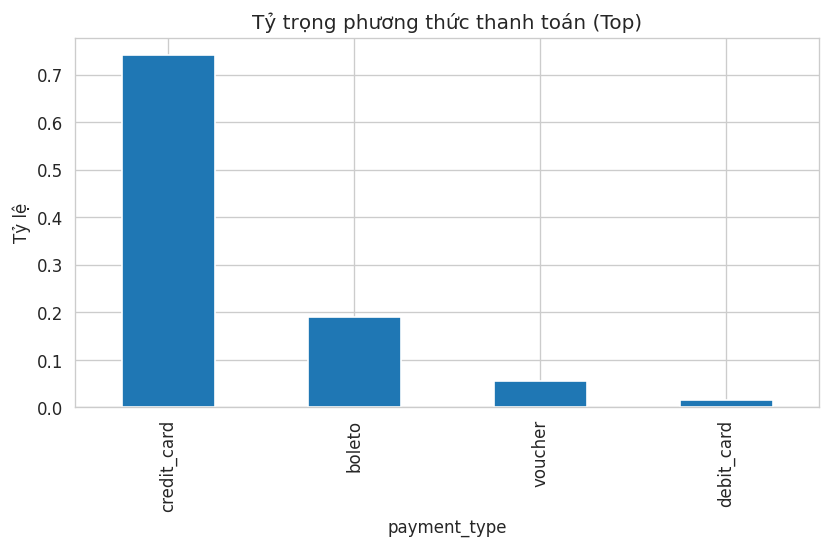

In [80]:
plt.figure(figsize=(8,4))
sns.histplot(trans['order_value'], bins=80, log_scale=True)
plt.title("Phân bố giá trị đơn hàng (log scale)")
plt.xlabel("Order Value (log)")
plt.ylabel("Số lượng")
plt.show()

# Phân phối số đơn theo khách
cust_orders = trans.groupby('customer_unique_id')['order_id'].nunique()
sns.histplot(cust_orders, bins=40)
plt.title("Số đơn hàng mỗi khách")
plt.xlabel("Số đơn")
plt.show()

# Thống kê khách mua 1 lần
total_customers = cust_orders.shape[0]
one_time_customers = cust_orders.eq(1).sum()
one_time_pct = (one_time_customers / total_customers * 100).round(2)

print(f"Tổng số khách: {total_customers}")
print(f"Số khách chỉ mua 1 lần: {one_time_customers}")
print(f"Tỷ lệ khách chỉ mua 1 lần: {one_time_pct}%")

# Tỷ trọng phương thức thanh toán
pm = payments.merge(orders[['order_id']], on='order_id', how='inner')
share = pm['payment_type'].value_counts(normalize=True).head(6)
share.plot(kind='bar', figsize=(8,4))
plt.title("Tỷ trọng phương thức thanh toán (Top)")
plt.ylabel("Tỷ lệ")
plt.show()


## 5.Tách thời gian (Cutoff & Horizon) + Chia Train/Test

Train orders: 43357 | Test (horizon): 40344


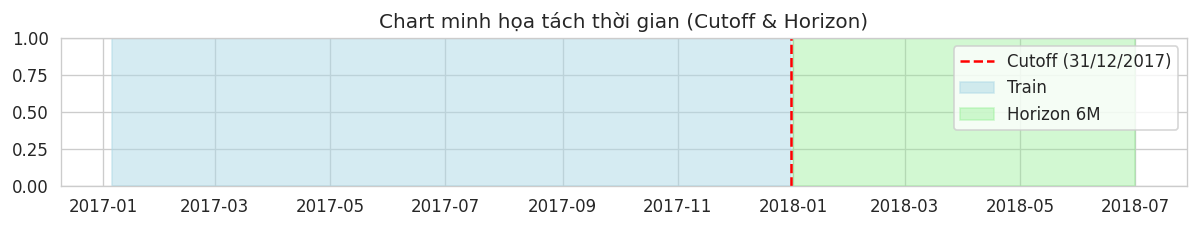

In [81]:
# Thiết lập mốc thời gian tách dữ liệu (temporal split)

# Trong đó:
# - CUTOFF: mốc tách train/test (31/12/2017)
# - H_START, H_END: giai đoạn dự báo CLV (01/2018–06/2018)
# - SNAPSHOT: điểm tham chiếu tính Recency

CUTOFF  = pd.Timestamp('2017-12-31')
H_START = CUTOFF + pd.Timedelta(days=1)
H_END   = H_START + pd.DateOffset(months=6)
SNAPSHOT = CUTOFF + pd.Timedelta(days=1)

# Chia dữ liệu:
# - train_tx: giao dịch trước cutoff (dùng huấn luyện)
# - test_tx : giao dịch sau cutoff (dùng đánh giá CLV thực tế)
train_tx = trans[trans['order_date'] <= CUTOFF].copy()
test_tx  = trans[(trans['order_date'] > CUTOFF) & (trans['order_date'] <= H_END)].copy()

# Lưu ý: Khách hàng chỉ xuất hiện sau cutoff (cold-start) sẽ bị loại tự động
# vì không có lịch sử trong train_tx → không thể dự báo CLV
print("Train orders:", len(train_tx), "| Test (horizon):", len(test_tx))

# Chart Cutoff & Horizon
plt.figure(figsize=(10,2))
plt.axvline(CUTOFF, color='r', linestyle='--', label='Cutoff (31/12/2017)')
plt.axvspan(train_tx['order_date'].min(), CUTOFF, color='lightblue', alpha=0.5, label='Train')
plt.axvspan(H_START, H_END, color='lightgreen', alpha=0.4, label='Horizon 6M')
plt.title("Chart minh họa tách thời gian (Cutoff & Horizon)")
plt.legend(); plt.tight_layout(); plt.show()


In [82]:
train_tx['customer_unique_id'].nunique()

42066

- Lúc này, tập train có khoảng 42066 unique customers

In [83]:
train_tx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43357 entries, 0 to 96475
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            43357 non-null  object        
 1   customer_unique_id  43357 non-null  object        
 2   order_date          43357 non-null  datetime64[ns]
 3   order_value         43357 non-null  float64       
 4   customer_state      43357 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ MB


## 6.Tính RFM (Recency–Frequency–Monetary)

In [84]:
# Tính RFM theo kiểu bình thường
# last  = ngày mua gần nhất (most recent purchase)
# first = ngày mua đầu tiên (khởi đầu mối quan hệ khách hàng)
# num   = số đơn hàng (frequency)
# spent = tổng tiền chi tiêu (monetary)

rfm_simple = (
    train_tx.groupby('customer_unique_id')
    .agg(
        last=('order_date', 'max'),      # lần mua gần nhất
        first=('order_date', 'min'),     # lần mua đầu tiên
        num=('order_id', 'nunique'),     # số đơn hàng duy nhất
        spent=('order_value', 'sum')     # tổng chi tiêu của khách
    )
)

rfm_simple['recency']   = (SNAPSHOT - rfm_simple['last']).dt.days
rfm_simple['T']         = (SNAPSHOT - rfm_simple['first']).dt.days
rfm_simple['frequency'] = rfm_simple['num']      # không trừ 1
rfm_simple['monetary']  = rfm_simple['spent'] / rfm_simple['num']

rfm_simple = rfm_simple[['recency', 'frequency', 'T', 'monetary']].reset_index()
rfm_simple.head(10)

,customer_unique_id,recency,frequency,T,monetary
0,0000f46a3911fa3c0805444483337064,296,1,296,86.22
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,80,43.62
2,0004aac84e0df4da2b147fca70cf8255,47,1,47,196.89
3,0005e1862207bf6ccc02e4228effd9a0,302,1,302,150.12
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,166,29.00
5,00082cbe03e478190aadbea78542e933,42,1,42,126.26
6,000a5ad9c4601d2bbdd9ed765d5213b3,142,1,142,91.28
7,000bfa1d2f1a41876493be685390d6d3,93,1,93,46.85
8,000c8bdb58a29e7115cfc257230fb21b,19,1,19,29.00
9,000de6019bb59f34c099a907c151d855,136,1,136,257.44


In [85]:
rfm_simple.describe()

,recency,frequency,T,monetary
count,42066.000000,42066.000000,42066.000000,42066.000000
mean,136.727904,1.030690,137.985713,159.910345
std,95.225573,0.194258,95.428175,226.197880
min,1.000000,1.000000,1.000000,10.070000
25%,47.000000,1.000000,48.000000,62.010000
50%,122.000000,1.000000,124.000000,104.190000
75%,212.000000,1.000000,214.000000,175.550000
max,360.000000,8.000000,360.000000,13664.080000


In [86]:
# Nhóm frequency
bins = [0, 1, 2, 3, rfm_simple['frequency'].max()]
labels = ['1', '2', '3', '>3']
rfm_simple['freq_group'] = pd.cut(rfm_simple['frequency'], bins=bins, labels=labels)

# Tính số user và %
freq_summary = rfm_simple['freq_group'].value_counts().sort_index().to_frame('num_users')
freq_summary['percent'] = (freq_summary['num_users'] / freq_summary['num_users'].sum() * 100).round(2)

print(freq_summary)


            num_users  percent
freq_group                    
1               40897    97.22
2                1076     2.56
3                  74     0.18
>3                 19     0.05


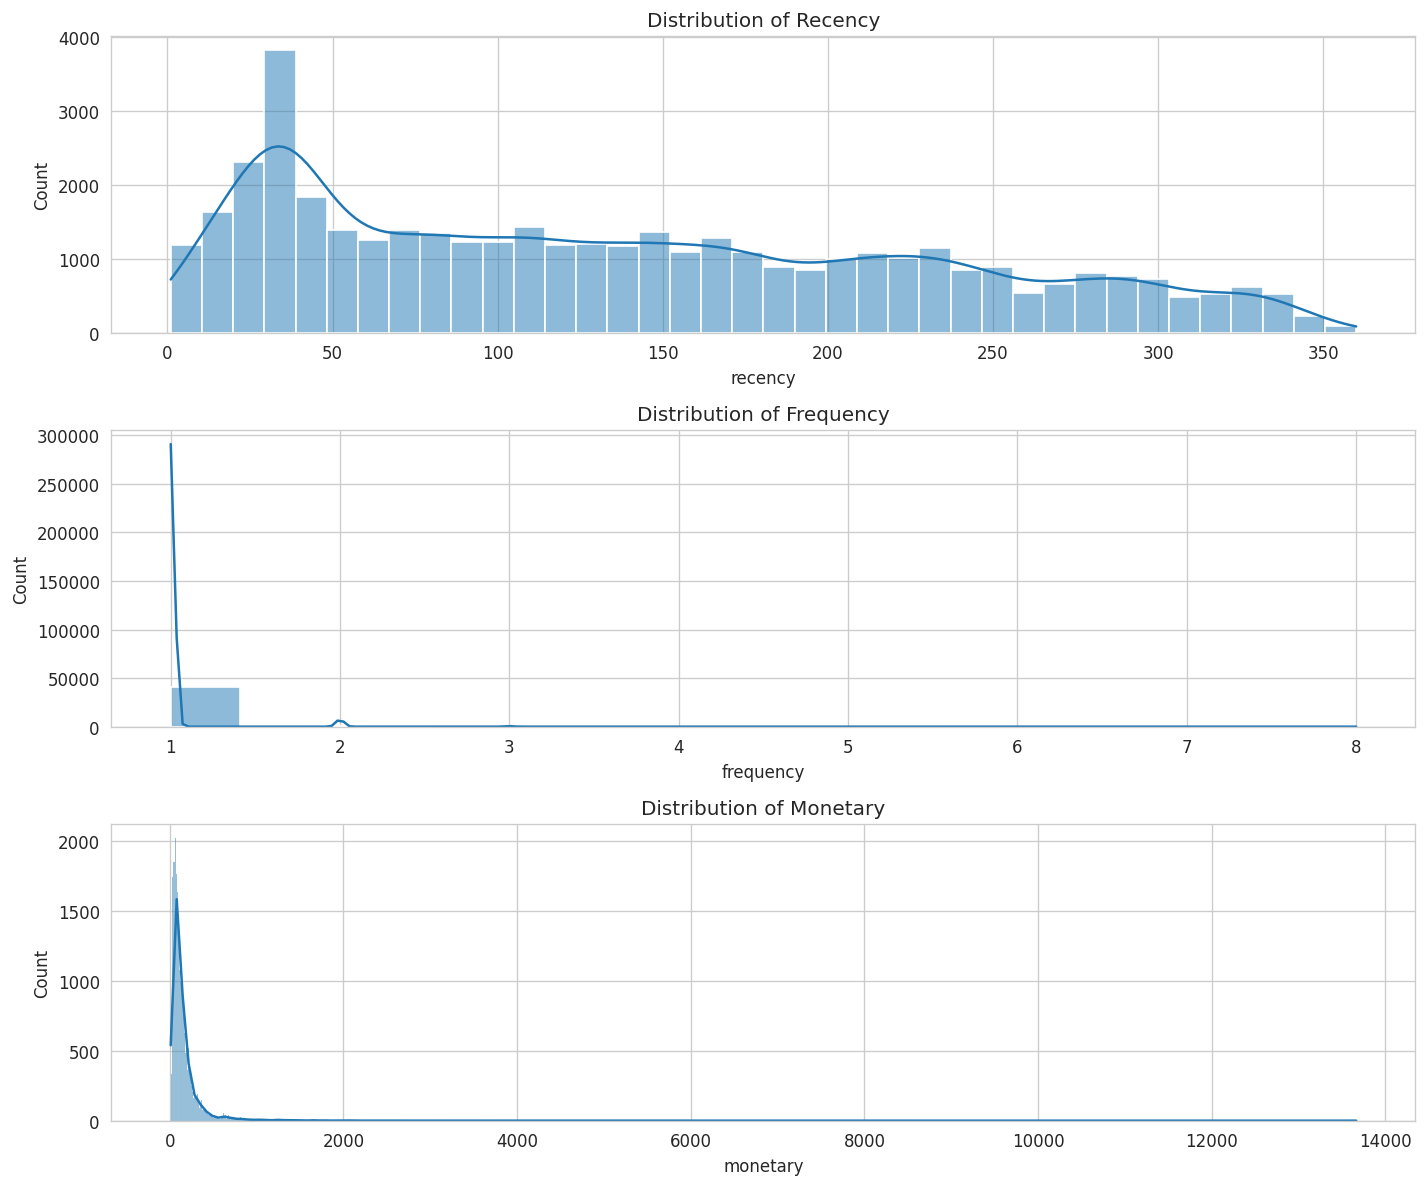

In [87]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.histplot(rfm_simple['recency'], kde=True)
plt.title('Distribution of Recency')

plt.subplot(3, 1, 2)
sns.histplot(rfm_simple['frequency'], kde=True)
plt.title('Distribution of Frequency')

plt.subplot(3, 1, 3)
sns.histplot(rfm_simple['monetary'], kde=True)
plt.title('Distribution of Monetary')

plt.tight_layout()
plt.show()


* Nhận xét về phân phối RFM:

- 1. Recency

    + Phần lớn khách hàng có recency thấp (mua gần đây), đỉnh cao nhất quanh 30–50 ngày
    + Có một số khách hàng rất lâu không mua, nhưng chiếm tỷ lệ nhỏ → khách trung thành và khách lâu không tương tác đều tồn tại

- 2. Frequency

    + Đa số khách chỉ mua 1 lần → tỉ lệ khách mua lại thấp
    + Số khách mua 2–3 lần và >3 lần giảm rất nhanh → phần lớn khách hàng chưa trở thành khách trung thành

- 3. Monetary

    + Phần lớn khách chi tiêu thấp, chỉ một số ít khách chi tiêu cao
    + Phân phối có long tail, vài khách hàng chi tiêu cực lớn

## 7.Cohort Retention

In [88]:
train_tx['order_month'] = train_tx['order_date'].dt.to_period('M')
first_month = train_tx.groupby('customer_unique_id')['order_month'].min().rename('cohort')
cohort_df = train_tx.merge(first_month, on='customer_unique_id', how='left')
cohort_df['cohort_index'] = (cohort_df['order_month'] - cohort_df['cohort']).apply(lambda p: p.n)

cohort_pivot = (
    cohort_df.groupby(['cohort', 'cohort_index'])['customer_unique_id']
    .nunique().unstack(1).fillna(0)
)
retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)


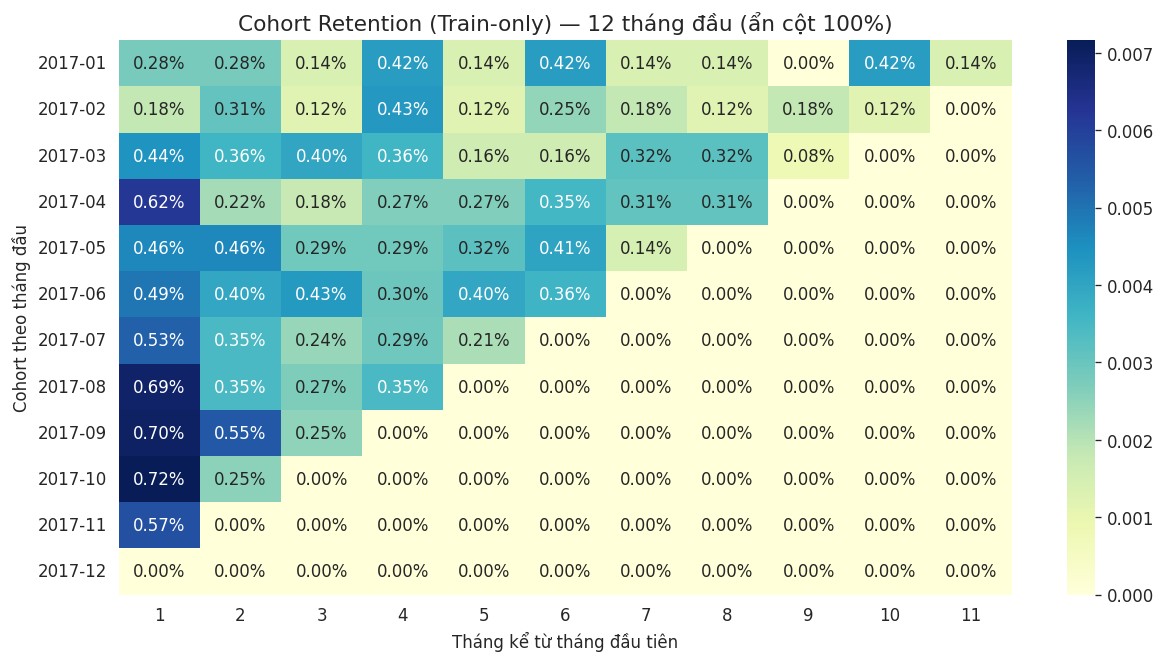

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Bỏ cột 0 (tháng đầu = 100%)
sns.heatmap(
    retention.iloc[:, 1:13],    # chỉ lấy từ tháng 1 đến tháng 12
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=True
)

plt.title("Cohort Retention (Train-only) — 12 tháng đầu (ẩn cột 100%)", fontsize=13)
plt.ylabel("Cohort theo tháng đầu")
plt.xlabel("Tháng kể từ tháng đầu tiên")
plt.show()


* Nhận xét tổng quan:

  - Tỷ lệ quay lại nhìn chung rất thấp, chỉ dao động quanh 0.2–0.7% ở tháng kế tiếp, rồi giảm nhanh về gần 0% sau 3–4 tháng

  - Đa số cohort đều có hiện tượng “rơi rụng nhanh”, đặc biệt từ tháng thứ 4 trở đi, gần như không còn khách quay lại
  
  - Điều này cho thấy phần lớn khách hàng chỉ phát sinh một lần mua, đúng với mô tả “one-time heavy” thường thấy trong thương mại điện tử marketplace

## 8.Baseline CLV – Fit BG/NBD & Gamma–Gamma

### 8.1. Tạo bảng RFM cho mô hình xác suất

In [90]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# ================================================================
# STEP 8.1: TẠO BẢNG RFM CHO MÔ HÌNH XÁC SUẤT
# ================================================================
# Tạo bảng tóm tắt hành vi mua (input cho lifetimes)

#   - F (Frequency): Số lần mua lặp lại (đã trừ đi giao dịch đầu tiên)
#   - T: Tuổi của khách hàng (tính từ lần mua đầu đến SNAPSHOT)

summary = summary_data_from_transaction_data(
    transactions=train_tx,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    monetary_value_col='order_value',
    observation_period_end=SNAPSHOT,  # Ngày kết thúc quan sát (31/12/2017)
    freq='D'
).reset_index()

summary = summary[summary['monetary_value'] >= 0]

print(f"Kích thước bảng Summary: {summary.shape}")
summary.head(5)

Kích thước bảng Summary: (42066, 5)


,customer_unique_id,frequency,recency,T,monetary_value
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0


### 8.2. Fit mô hình BG/NBD & Gamma-Gamma

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================================================================
# STEP 8.2: FIT MÔ HÌNH BG/NBD & GAMMA-GAMMA
# ================================================================

# 1. Fit mô hình BG/NBD (Dự báo tần suất mua)
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# 2. Fit mô hình Gamma–Gamma (Dự báo chi tiêu trung bình)
# Chỉ fit trên khách hàng có frequency > 0 (mua lặp lại)
mask_rep = (summary['frequency'] > 0) & (summary['monetary_value'] > 0)
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary.loc[mask_rep,'frequency'], summary.loc[mask_rep,'monetary_value'])



<lifetimes.GammaGammaFitter: fitted with 709 subjects, p: 4.13, q: 0.50, v: 3.86>

In [92]:
# 3. Dự báo cho giai đoạn Holdout (6 tháng tới)
H_days = (H_END - H_START).days + 1
print(f"Dự báo cho {H_days} ngày tiếp theo...")

# Dự báo số giao dịch
summary['pred_purchases_6m'] = bgf.predict(H_days, summary['frequency'], summary['recency'], summary['T'])

# Dự báo giá trị trung bình (Conditional Expected Average Profit)

summary['pred_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# Dự báo CLV = Số giao dịch * Giá trị trung bình
summary['CLV_prob_6m'] = summary['pred_purchases_6m'] * summary['pred_avg_value']

# Xác suất còn hoạt động (P_alive)
summary['p_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

# --- KIỂM TRA KẾT QUẢ ---
print("\nThống kê mô tả kết quả dự báo (Probabilistic Models):")
print(summary[['pred_purchases_6m', 'pred_avg_value', 'CLV_prob_6m', 'p_alive']].describe().T)

Dự báo cho 182 ngày tiếp theo...

Thống kê mô tả kết quả dự báo (Probabilistic Models):
                     count       mean        std        min        25%  \
pred_purchases_6m  42066.0   0.015150   0.073366   0.005220   0.007645   
pred_avg_value     42066.0 -28.435857  35.754280 -31.895107 -31.895107   
CLV_prob_6m        42066.0   0.183047  12.651671  -0.810176  -0.516855   
p_alive            42066.0   0.985447   0.114014   0.020397   1.000000   

                         50%        75%          max  
pred_purchases_6m   0.010712   0.016568     6.992037  
pred_avg_value    -31.895107 -31.895107  1881.447987  
CLV_prob_6m        -0.334119  -0.238594  1004.150835  
p_alive             1.000000   1.000000     1.000000  


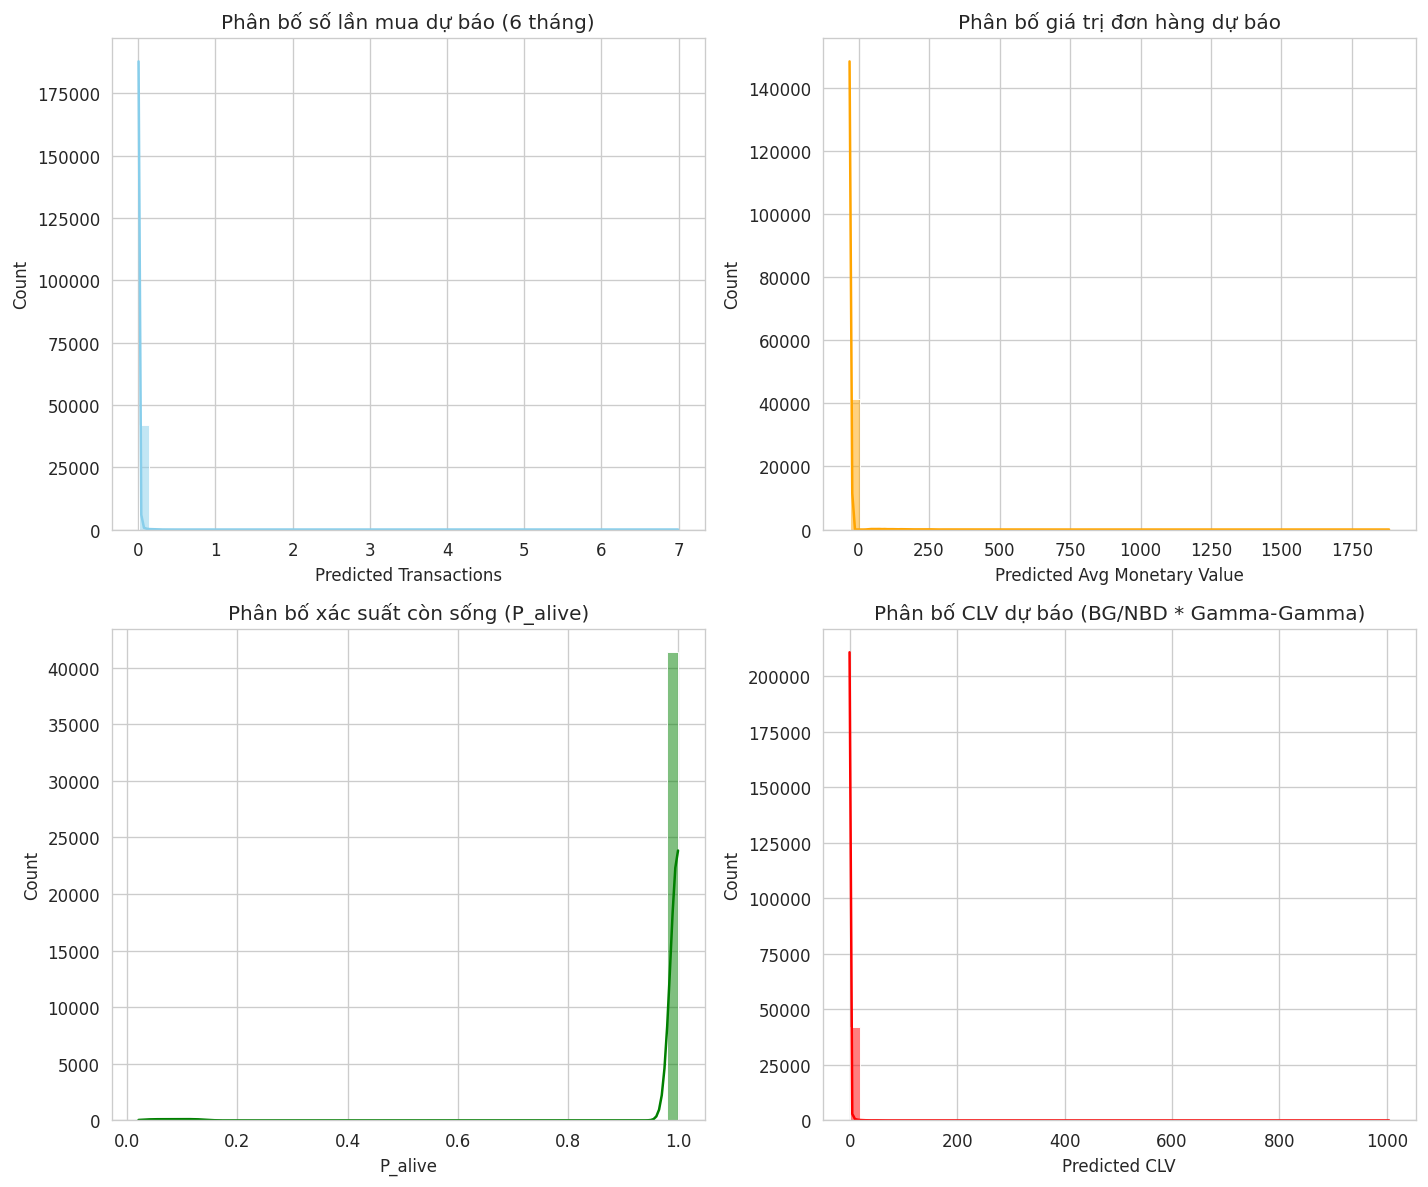

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.histplot(summary['pred_purchases_6m'], kde=True, bins=50, color='skyblue')
plt.title('Phân bố số lần mua dự báo (6 tháng)')
plt.xlabel('Predicted Transactions')

plt.subplot(2, 2, 2)
sns.histplot(summary['pred_avg_value'], kde=True, bins=50, color='orange')
plt.title('Phân bố giá trị đơn hàng dự báo')
plt.xlabel('Predicted Avg Monetary Value')

plt.subplot(2, 2, 3)
sns.histplot(summary['p_alive'], kde=True, bins=50, color='green')
plt.title('Phân bố xác suất còn sống (P_alive)')
plt.xlabel('P_alive')

plt.subplot(2, 2, 4)
sns.histplot(summary['CLV_prob_6m'], kde=True, bins=50, color='red')
plt.title('Phân bố CLV dự báo (BG/NBD * Gamma-Gamma)')
plt.xlabel('Predicted CLV')

plt.tight_layout()
plt.show()

### 8.3. CALIBRATION DECILE
* Dùng để đánh giá độ tin cậy của toàn bộ mô hình xác suất (BG/NBD + GG)

In [94]:
from lifetimes.utils import calibration_and_holdout_data
cal_hold_df = calibration_and_holdout_data(
    transactions=trans,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    monetary_value_col='order_value',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    freq='D'
)
bgf_cal = BetaGeoFitter(penalizer_coef=0.01)
bgf_cal.fit(cal_hold_df['frequency_cal'], cal_hold_df['recency_cal'], cal_hold_df['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 42066 subjects, a: 0.07, alpha: 46.51, b: 0.01, r: 0.01>

Thời gian dự báo (Horizon): 181 ngày (Từ 2017-12-31 đến 2018-06-30)

--- BIỂU ĐỒ HIỆU CHỈNH (CALIBRATION PLOT) ---


<Figure size 1200x840 with 0 Axes>

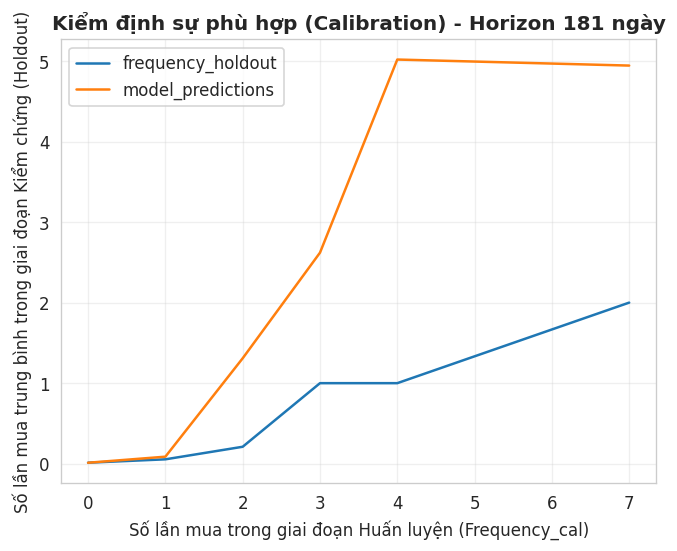


--- SỐ LIỆU BIỆN LUẬN (ĐÃ KHỚP THỜI GIAN) ---
1. Trung bình số lần mua THỰC TẾ (Holdout): 0.0138
2. Trung bình số lần mua DỰ BÁO (Model):    0.0153
=> KẾT LUẬN: Mô hình dự báo cao hơn thực tế (Over-prediction): 10.73%


In [95]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. THIẾT LẬP THỜI GIAN CHUẨN ---
cutoff_date = pd.to_datetime('2017-12-31')
end_date = pd.to_datetime('2018-06-30')

# Tính chính xác số ngày trong giai đoạn Holdout
days_holdout = (end_date - cutoff_date).days
print(f"Thời gian dự báo (Horizon): {days_holdout} ngày (Từ {cutoff_date.date()} đến {end_date.date()})")

# --- 2. VẼ BIỂU ĐỒ HIỆU CHỈNH ---
print("\n--- BIỂU ĐỒ HIỆU CHỈNH (CALIBRATION PLOT) ---")
plt.figure(figsize=(10, 7))

ax = plot_calibration_purchases_vs_holdout_purchases(
    bgf_cal,
    cal_hold_df,
    n=7,
    label='Dự báo (Model)',
)

plt.title(f'Kiểm định sự phù hợp (Calibration) - Horizon {days_holdout} ngày', fontsize=12, fontweight='bold')
plt.xlabel('Số lần mua trong giai đoạn Huấn luyện (Frequency_cal)', fontsize=10)
plt.ylabel('Số lần mua trung bình trong giai đoạn Kiểm chứng (Holdout)', fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. TÍNH TOÁN ĐỘ LỆCH (OVER-PREDICTION) ---
summary_cal = cal_hold_df.copy()

# Dự báo với số ngày chính xác (days_holdout)
summary_cal['pred_holdout'] = bgf_cal.predict(
    days_holdout,
    summary_cal['frequency_cal'],
    summary_cal['recency_cal'],
    summary_cal['T_cal']
)

actual_mean = summary_cal['frequency_holdout'].mean()
pred_mean = summary_cal['pred_holdout'].mean()

if actual_mean > 0:
    gap_percent = ((pred_mean - actual_mean) / actual_mean) * 100
else:
    gap_percent = 0

print(f"\n--- SỐ LIỆU BIỆN LUẬN (ĐÃ KHỚP THỜI GIAN) ---")
print(f"1. Trung bình số lần mua THỰC TẾ (Holdout): {actual_mean:.4f}")
print(f"2. Trung bình số lần mua DỰ BÁO (Model):    {pred_mean:.4f}")
print(f"=> KẾT LUẬN: Mô hình dự báo cao hơn thực tế (Over-prediction): {gap_percent:.2f}%")

In [96]:
len(summary_cal)

42066

### 8.4. Gắn nhãn CLV thực tế & tạo Feature Set

In [97]:
from sklearn.metrics import mean_absolute_error, r2_score

# --- BƯỚC 1: TÍNH TOÁN & GÁN NHÃN THỰC TẾ (TARGET) ---
# Nhãn thật (chi tiêu thực tế trong Horizon - 6 tháng đầu 2018) từ tập test_tx
y_true = (
    test_tx.groupby('customer_unique_id')['order_value'].sum()
    .rename('CLV_actual_6m')
)

# Merge vào bảng summary hiện có (đã chứa p_alive, CLV_prob_6m, RFM)
summary = summary.merge(y_true, on='customer_unique_id', how='left')
summary['CLV_actual_6m'] = summary['CLV_actual_6m'].fillna(0.0)

# --- BƯỚC 2: ĐÁNH GIÁ NHANH MÔ HÌNH XÁC SUẤT & DỮ LIỆU ---
# Đánh giá hiệu suất dự báo của Gamma-Gamma so với thực tế
mae_prob = mean_absolute_error(summary['CLV_actual_6m'], summary['CLV_prob_6m'])
r2_prob = r2_score(summary['CLV_actual_6m'], summary['CLV_prob_6m'])

# Kiểm tra tỷ lệ Zero (Zero-Inflation)
zero_clv_count = (summary['CLV_actual_6m'] == 0).sum()
zero_ratio = zero_clv_count / len(summary) * 100

print(f"\n--- ĐÁNH GIÁ SƠ BỘ DỮ LIỆU & MÔ HÌNH XÁC SUẤT ---")
print(f"MAE (BG/NBD+GG): {mae_prob:.4f}")
print(f"R-squared (BG/NBD+GG): {r2_prob:.4f}")

# --- BƯỚC 3: TẠO & BỔ SUNG FEATURE HÀNH VI MỞ RỘNG (FEATURES) ---
# Tính toán các đặc trưng hành vi từ lịch sử (train_tx)
agg_base = train_tx[['order_id','customer_unique_id','customer_state']].copy()

feat_aggs = (
    agg_base
    .merge(payments[['order_id','payment_value']], on='order_id', how='left')
    .merge(reviews[['order_id','review_score']], on='order_id', how='left')
    .merge(items[['order_id','product_id']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('payment_value','sum'),
        payment_value_mean  = ('payment_value','mean'),
        review_score_mean   = ('review_score','mean'),
        num_unique_products = ('product_id', pd.Series.nunique),
        state_mode          = ('customer_state', lambda x: x.mode()[0] if len(x.mode())>0 else np.nan)
    ).reset_index()
)

# --- BƯỚC 4: TẠO BẢNG DỮ LIỆU ML CUỐI CÙNG (summary_ml) ---
# Merge features hành vi vào bảng summary
summary_ml = summary.merge(feat_aggs, on='customer_unique_id', how='left')

# Xử lý giá trị thiếu cho cột review
median_review = summary_ml['review_score_mean'].median()
summary_ml['review_score_mean'] = summary_ml['review_score_mean'].fillna(median_review)

print(f"\n--- KẾT QUẢ: Đã tạo thành công summary_ml ---")
print(f"Kích thước: {summary_ml.shape}")
print(summary_ml.head(3))



--- ĐÁNH GIÁ SƠ BỘ DỮ LIỆU & MÔ HÌNH XÁC SUẤT ---
MAE (BG/NBD+GG): 2.8311
R-squared (BG/NBD+GG): -0.1865

--- KẾT QUẢ: Đã tạo thành công summary_ml ---
Kích thước: (42066, 15)
                 customer_unique_id  frequency  recency      T  \
0  0000f46a3911fa3c0805444483337064        0.0      0.0  297.0   
1  0000f6ccb0745a6a4b88665a16c9f078        0.0      0.0   81.0   
2  0004aac84e0df4da2b147fca70cf8255        0.0      0.0   48.0   

   monetary_value  pred_purchases_6m  pred_avg_value  CLV_prob_6m  p_alive  \
0             0.0           0.006040      -31.895107    -0.192632      1.0   
1             0.0           0.013189      -31.895107    -0.420656      1.0   
2             0.0           0.016324      -31.895107    -0.520655      1.0   

   CLV_actual_6m  payment_value_sum  payment_value_mean  review_score_mean  \
0            0.0              86.22               86.22                3.0   
1            0.0              43.62               43.62                4.0   
2          

### 8.5. Chạy mô hình xác suất với tệp con

--- KỊCH BẢN 3: TRAIN TOÀN BỘ - ĐÁNH GIÁ SUBSET ---
Calibration End: 2017-12-31 00:00:00
Tổng số khách hàng (Full): 42066
Số lượng khách hàng đánh giá (Subset): 709

--- KẾT QUẢ ĐÁNH GIÁ BG/NBD (TRÊN SUBSET) ---
1. RMSE: 0.3294
2. MAE:  0.1306
3. R2 Score: 0.1215


<Figure size 1200x600 with 0 Axes>

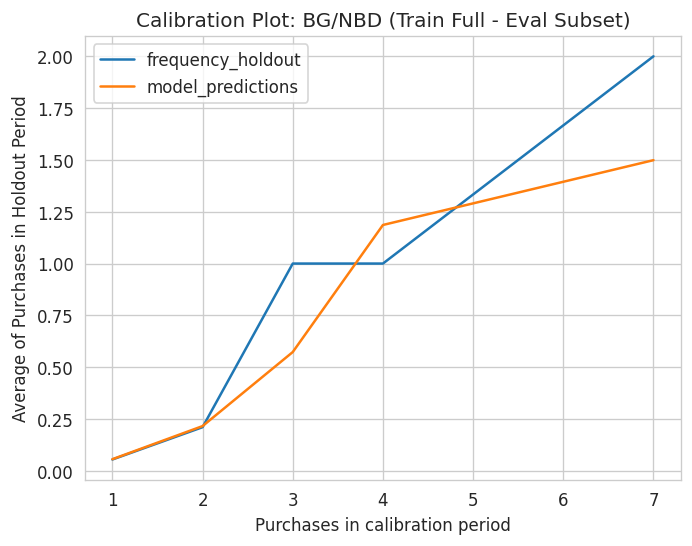

In [98]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. CHUẨN BỊ DỮ LIỆU GỐC & MỐC THỜI GIAN ---

trans_ready = trans.copy().rename(columns={
    'order_purchase_timestamp': 'order_date',
    'payment_value': 'order_value',
    'date': 'order_date',
    'value': 'order_value'
})
trans_ready = trans_ready[trans_ready['order_value'] > 0]

CUTOFF = pd.Timestamp('2017-12-31')
H_END  = pd.Timestamp('2018-06-30')

print(f"--- KỊCH BẢN 3: TRAIN TOÀN BỘ - ĐÁNH GIÁ SUBSET ---")
print(f"Calibration End: {CUTOFF}")

# --- 2. TẠO MA TRẬN RFM TOÀN BỘ (FULL DATASET) ---
# Tạo RFM cho TẤT CẢ khách hàng
rfm_full = calibration_and_holdout_data(
    transactions=trans_ready,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    monetary_value_col='order_value',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    freq='D'
)
print(f"Tổng số khách hàng (Full): {len(rfm_full)}")

# --- 3. HUẤN LUYỆN BG/NBD TRÊN TOÀN BỘ DỮ LIỆU ---
# Học tham số quần thể từ tập Full
bgf_full = BetaGeoFitter(penalizer_coef=0.0)
bgf_full.fit(
    rfm_full['frequency_cal'],
    rfm_full['recency_cal'],
    rfm_full['T_cal']
)

# --- 4. TÁCH SUBSET & ĐÁNH GIÁ TRÊN SUBSET ---
# Lọc ra nhóm khách hàng lặp lại (Subset) để đánh giá
subset_eval = rfm_full[rfm_full['frequency_cal'] > 0].copy()
print(f"Số lượng khách hàng đánh giá (Subset): {len(subset_eval)}")

# Dự báo cho nhóm Subset (dùng mô hình đã train trên Full)
t_days = (H_END - CUTOFF).days
pred_freq_subset = bgf_full.predict(
    t_days,
    subset_eval['frequency_cal'],
    subset_eval['recency_cal'],
    subset_eval['T_cal']
)
actual_freq_subset = subset_eval['frequency_holdout']

# Tính chỉ số
rmse_bg = np.sqrt(mean_squared_error(actual_freq_subset, pred_freq_subset))
mae_bg = mean_absolute_error(actual_freq_subset, pred_freq_subset)
r2_bg = r2_score(actual_freq_subset, pred_freq_subset)

print("\n--- KẾT QUẢ ĐÁNH GIÁ BG/NBD (TRÊN SUBSET) ---")
print(f"1. RMSE: {rmse_bg:.4f}")
print(f"2. MAE:  {mae_bg:.4f}")
print(f"3. R2 Score: {r2_bg:.4f}")

# Vẽ biểu đồ Calibration (Vẽ trên tập Subset để xem độ khớp)
plt.figure(figsize=(10, 5))
plot_calibration_purchases_vs_holdout_purchases(bgf_full, subset_eval, n=7)
plt.title('Calibration Plot: BG/NBD (Train Full - Eval Subset)')
plt.show()

In [99]:
from lifetimes import GammaGammaFitter
from scipy.stats import pearsonr

# --- 1. CHUẨN BỊ DỮ LIỆU GAMMA-GAMMA (TỪ SUBSET) ---
# Chỉ lấy khách hàng lặp lại và có giá trị dương
gg_data = subset_eval[subset_eval['monetary_value_cal'] > 0].copy()

# --- 2. KIỂM TRA GIẢ ĐỊNH ĐỘC LẬP ---
corr_val, p_val = pearsonr(gg_data['frequency_cal'], gg_data['monetary_value_cal'])
print(f"\n--- KIỂM ĐỊNH GIẢ ĐỊNH ĐỘC LẬP ---")
print(f"Correlation (Freq vs Monetary): {corr_val:.4f}")
if abs(corr_val) < 0.1:
    print("=> Nhận xét: Tương quan thấp. Giả định ĐỘC LẬP được thỏa mãn.")
else:
    print("=> Nhận xét: Có tương quan. Giả định bị vi phạm.")

# --- 3. HUẤN LUYỆN GAMMA-GAMMA ---
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(gg_data['frequency_cal'], gg_data['monetary_value_cal'])

# --- 4. ĐÁNH GIÁ DỰ BÁO GIÁ TRỊ (AOV) TRÊN SUBSET ---
# Lọc khách có mua trong holdout để so sánh
eval_mask = gg_data['monetary_value_holdout'] > 0
gg_eval_set = gg_data[eval_mask]

if len(gg_eval_set) > 0:
    pred_monetary = ggf.conditional_expected_average_profit(
        gg_eval_set['frequency_cal'],
        gg_eval_set['monetary_value_cal']
    )
    actual_monetary = gg_eval_set['monetary_value_holdout']

    rmse_m = np.sqrt(mean_squared_error(actual_monetary, pred_monetary))
    r2_m = r2_score(actual_monetary, pred_monetary)

    print("\n--- ĐÁNH GIÁ GAMMA-GAMMA (TRÊN SUBSET) ---")
    print(f"1. RMSE: {rmse_m:.2f}")
    print(f"2. R2 Score: {r2_m:.4f}")
else:
    print("Không đủ dữ liệu kiểm chứng Monetary.")


--- KIỂM ĐỊNH GIẢ ĐỊNH ĐỘC LẬP ---
Correlation (Freq vs Monetary): -0.0024
=> Nhận xét: Tương quan thấp. Giả định ĐỘC LẬP được thỏa mãn.

--- ĐÁNH GIÁ GAMMA-GAMMA (TRÊN SUBSET) ---
1. RMSE: 194.29
2. R2 Score: -0.6476


In [100]:
# ================================================================
# DỰ BÁO CLV TỔNG HỢP
# ================================================================

# 1. Dự báo CLV trên tập Holdout (Subset)
# Kết hợp BG/NBD (Train Full) và Gamma-Gamma (Train Subset)
pred_clv = ggf.customer_lifetime_value(
    bgf_full, # Dùng mô hình Full
    gg_data['frequency_cal'],
    gg_data['recency_cal'],
    gg_data['T_cal'],
    gg_data['monetary_value_cal'],
    time=t_days,
    freq='D',
    discount_rate=0.0
)

actual_clv = gg_data['frequency_holdout'] * gg_data['monetary_value_holdout']

rmse_clv = np.sqrt(mean_squared_error(actual_clv, pred_clv))
mae_clv = mean_absolute_error(actual_clv, pred_clv)
r2_clv = r2_score(actual_clv, pred_clv)

print("\n--- ĐÁNH GIÁ DỰ BÁO CLV (TRÊN SUBSET) ---")
print(f"1. RMSE: {rmse_clv:.2f}")
print(f"2. MAE:  {mae_clv:.2f}")
print(f"3. R2 Score: {r2_clv:.4f}")

# 2. Dự báo Tương lai (6 tháng tới)
future_days = 180
future_clv = ggf.customer_lifetime_value(
    bgf_full,
    gg_data['frequency_cal'],
    gg_data['recency_cal'],
    gg_data['T_cal'],
    gg_data['monetary_value_cal'],
    time=future_days,
    freq='D',
    discount_rate=0.01
)

print(f"\n--- DỰ BÁO TƯƠNG LAI (NHÓM SUBSET) ---")
print(f"Tổng doanh thu dự kiến: {future_clv.sum():,.0f} VND")
print(f"CLV trung bình/khách:   {future_clv.mean():,.0f} VND")


--- ĐÁNH GIÁ DỰ BÁO CLV (TRÊN SUBSET) ---
1. RMSE: 92.03
2. MAE:  40.12
3. R2 Score: -0.4287

--- DỰ BÁO TƯƠNG LAI (NHÓM SUBSET) ---
Tổng doanh thu dự kiến: 19,779 VND
CLV trung bình/khách:   28 VND



PHÂN TÍCH CHI TIẾT ĐỘ PHÂN TÁN (VARIANCE ANALYSIS)
1. THỐNG KÊ CƠ BẢN:
   - Trung bình (Mean):   149.44
   - Trung vị (Median):   104.30
   - Độ lệch chuẩn (Std): 163.64
   - Min: 14.08 | Max: 1,650.18
----------------------------------------
2. ĐÁNH GIÁ ĐỘ PHÂN TÁN & HÌNH DÁNG:
   - Hệ số biến thiên (CV): 1.0950
     (CV > 1: Phân tán RẤT CAO -> Rủi ro cho Gamma-Gamma)
   - Độ lệch (Skewness):    4.3071
     (Skew > 1: Phân phối lệch phải mạnh -> Nhiều đơn hàng giá trị nhỏ, ít đơn cực lớn)
   - Độ nhọn (Kurtosis):    25.9141
     (Kurt > 3: Đuôi phân phối rất dày -> Nhiều giá trị ngoại lai/Outliers)
----------------------------------------
=> KẾT LUẬN:
   CẢNH BÁO: Dữ liệu có PHƯƠNG SAI QUÁ LỚN (High Variance)
   Lý do: Độ lệch chuẩn còn lớn hơn cả giá trị trung bình
   Hệ quả: Mô hình Gamma-Gamma sẽ gặp khó khăn lớn trong việc hội tụ


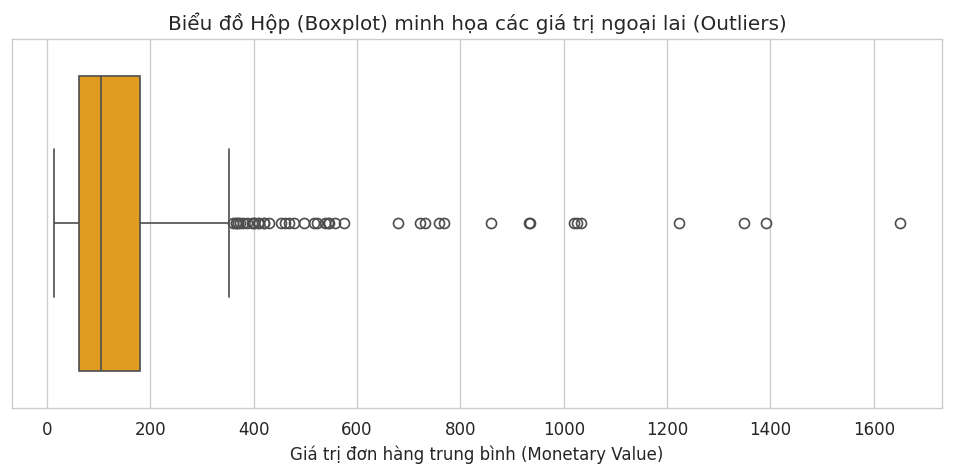

In [101]:
import scipy.stats as stats

# --- KIỂM ĐỊNH CHI TIẾT ĐỘ PHÂN TÁN ---
# Dữ liệu: Giá trị đơn hàng trung bình của khách lặp lại
monetary_data = gg_data['monetary_value_cal']

print("\n" + "="*60)
print("PHÂN TÍCH CHI TIẾT ĐỘ PHÂN TÁN (VARIANCE ANALYSIS)")
print("="*60)

# 1. CÁC CHỈ SỐ THỐNG KÊ MÔ TẢ
mean_val = monetary_data.mean()
median_val = monetary_data.median()
std_val = monetary_data.std()
min_val = monetary_data.min()
max_val = monetary_data.max()

# 2. CÁC CHỈ SỐ ĐO LƯỜNG HÌNH DÁNG PHÂN PHỐI
# Hệ số biến thiên (CV): Đo độ phân tán tương đối
cv = std_val / mean_val
# Độ lệch (Skewness): Đo độ lệch của đuôi phân phối
skew = monetary_data.skew()
# Độ nhọn (Kurtosis): Đo độ dày của đuôi (Outliers)
kurt = monetary_data.kurtosis()

print(f"1. THỐNG KÊ CƠ BẢN:")
print(f"   - Trung bình (Mean):   {mean_val:,.2f}")
print(f"   - Trung vị (Median):   {median_val:,.2f}")
print(f"   - Độ lệch chuẩn (Std): {std_val:,.2f}")
print(f"   - Min: {min_val:,.2f} | Max: {max_val:,.2f}")
print("-" * 40)
print(f"2. ĐÁNH GIÁ ĐỘ PHÂN TÁN & HÌNH DÁNG:")
print(f"   - Hệ số biến thiên (CV): {cv:.4f}")
print(f"     (CV > 1: Phân tán RẤT CAO -> Rủi ro cho Gamma-Gamma)")
print(f"   - Độ lệch (Skewness):    {skew:.4f}")
print(f"     (Skew > 1: Phân phối lệch phải mạnh -> Nhiều đơn hàng giá trị nhỏ, ít đơn cực lớn)")
print(f"   - Độ nhọn (Kurtosis):    {kurt:.4f}")
print(f"     (Kurt > 3: Đuôi phân phối rất dày -> Nhiều giá trị ngoại lai/Outliers)")

# 3. KẾT LUẬN
print("-" * 40)
print("=> KẾT LUẬN:")
if cv > 1:
    print("   CẢNH BÁO: Dữ liệu có PHƯƠNG SAI QUÁ LỚN (High Variance)")
    print("   Lý do: Độ lệch chuẩn còn lớn hơn cả giá trị trung bình")
    print("   Hệ quả: Mô hình Gamma-Gamma sẽ gặp khó khăn lớn trong việc hội tụ")
else:
    print("   Dữ liệu có độ phân tán chấp nhận được")

# 4. BIỂU ĐỒ BOXPLOT
plt.figure(figsize=(10, 4))
sns.boxplot(x=monetary_data, color='orange')
plt.title('Biểu đồ Hộp (Boxplot) minh họa các giá trị ngoại lai (Outliers)')
plt.xlabel('Giá trị đơn hàng trung bình (Monetary Value)')
plt.show()

## 9.Xây dựng Bộ tiền xử lý (Preprocessor)

In [102]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = [
    'frequency', 'recency', 'T', 'monetary_value',
    'payment_value_sum', 'payment_value_mean',
    'review_score_mean', 'num_unique_products'
]

categorical_features = ['state_mode']

print(f"Numeric Features ({len(numeric_features)}): {numeric_features}")
print("Categorical Features:", categorical_features)

# 2. Pipeline cho numeric: Imputer + StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Pipeline cho categorical: Imputer + OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    ))
])

# 4. ColumnTransformer kết hợp 2 nhánh trên
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    verbose_feature_names_out=False
)



Numeric Features (8): ['frequency', 'recency', 'T', 'monetary_value', 'payment_value_sum', 'payment_value_mean', 'review_score_mean', 'num_unique_products']
Categorical Features: ['state_mode']


## 10.Cross-Validation & Lựa chọn Mô hình Tốt nhất

### 10.1. Chạy XG TWO-PART chung

Training Data Shape: (33652, 9)
Scale Weight: 77.44

KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI
Classification Report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9886    0.6904    0.8130      8307
           1     0.0157    0.3832    0.0301       107

    accuracy                         0.6865      8414
   macro avg     0.5022    0.5368    0.4216      8414
weighted avg     0.9762    0.6865    0.8031      8414

ROC AUC : 0.5364
PR  AUC : 0.0377


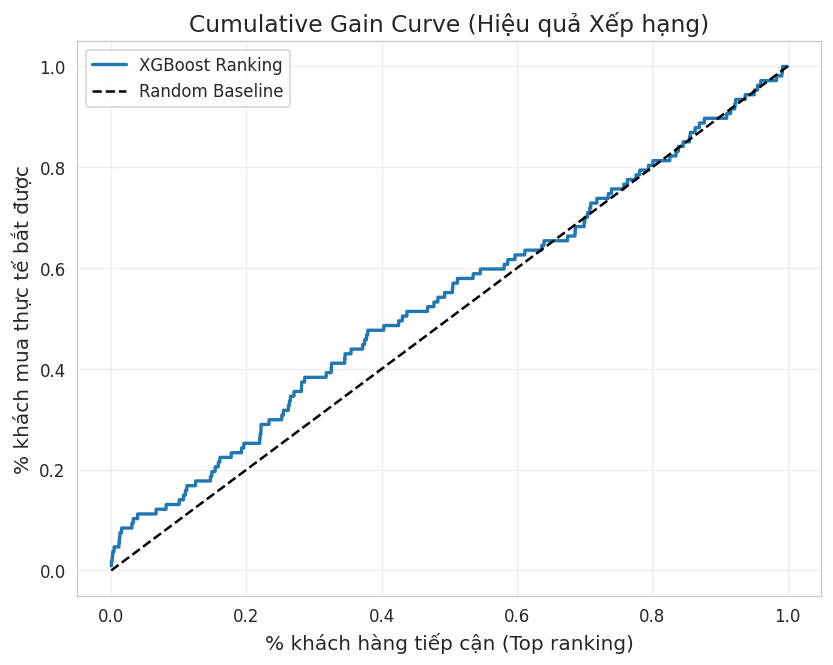

Total positives trong test: 107
Top  1% khách hàng: bắt được 5/107 khách quay lại (4.7%)
Top  5% khách hàng: bắt được 12/107 khách quay lại (11.2%)
Top 10% khách hàng: bắt được 14/107 khách quay lại (13.1%)
Top 20% khách hàng: bắt được 27/107 khách quay lại (25.2%)

KẾT QUẢ GIAI ĐOẠN 2: HỒI QUY (CHỈ KHÁCH QUAY LẠI)
Số khách quay lại trong test: 107
MAE Regressor (chỉ khách >0): 93.16
Giá trị trung bình thực tế:    149.49
Tỷ lệ sai số (MAE/mean):      62.3%

KẾT QUẢ CLV_FINAL = P * V
MAE CLV_final (toàn bộ khách):       51.68
MAE CLV_final (chỉ khách quay lại):  102.90


In [103]:
# ================================================================
# STEP 11: XGBOOST TWO-PART & RANKING (KHÔNG DÙNG FEATURE BG/NBD)
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    classification_report,
    mean_absolute_error,
    roc_auc_score,
    average_precision_score
)

# 1. Chuẩn bị dữ liệu (Data Prep)
# -----------------------------------------
summary_ml['y_cls'] = (summary_ml['CLV_actual_6m'] > 0).astype(int)

X = summary_ml[numeric_features + categorical_features]
y_cls = summary_ml['y_cls']
y_val = summary_ml['CLV_actual_6m']

X_train, X_test, y_cls_train, y_cls_test, y_val_train, y_val_test = train_test_split(
    X, y_cls, y_val,
    test_size=0.2,
    random_state=42,
    stratify=y_cls
)

# Dữ liệu cho Hồi quy (chỉ những khách có CLV > 0 trong train)
mask_train_pos = y_val_train > 0
X_train_reg = X_train[mask_train_pos]
y_train_reg_log = np.log1p(y_val_train[mask_train_pos])

# Tính scale_pos_weight cho Classifier
scale_weight = (y_cls_train == 0).sum() / (y_cls_train == 1).sum()
print(f"Training Data Shape: {X_train.shape}")
print(f"Scale Weight: {scale_weight:.2f}")


# 2. Huấn luyện Mô hình (Training)
# -----------------------------------------

pipe_cls = Pipeline([
    ('preprocess', clone(preprocessor)),
    ('model', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_weight,
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])
pipe_cls.fit(X_train, y_cls_train)


pipe_reg = Pipeline([
    ('preprocess', clone(preprocessor)),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_reg.fit(X_train_reg, y_train_reg_log)


# 3. Đánh giá & Kết quả (Evaluation)
# -----------------------------------------

# --- A. GIAI ĐOẠN 1: PHÂN LOẠI & RANKING ---
y_proba_cls = pipe_cls.predict_proba(X_test)[:, 1]
y_pred_cls = (y_proba_cls >= 0.5).astype(int)

print("\n" + "="*50)
print("KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI")
print("="*50)
print("Classification Report (thr=0.5):")
print(classification_report(y_cls_test, y_pred_cls, digits=4))
print(f"ROC AUC : {roc_auc_score(y_cls_test, y_proba_cls):.4f}")
print(f"PR  AUC : {average_precision_score(y_cls_test, y_proba_cls):.4f}")

# Ranking: Cumulative Gain
def plot_gain_manual(y_true, y_proba):
    df = pd.DataFrame({'y': y_true, 'p': y_proba}).sort_values('p', ascending=False)
    df['cum_pos'] = df['y'].cumsum()
    total_pos = df['y'].sum()
    if total_pos == 0:
        print("Không có khách quay lại trong tập test -> không vẽ gain.")
        return
    df['gain'] = df['cum_pos'] / total_pos
    df['percent'] = (np.arange(len(df)) + 1) / len(df)

    plt.figure(figsize=(8, 6))
    plt.plot(df['percent'], df['gain'], label='XGBoost Ranking', lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
    plt.title('Cumulative Gain Curve (Hiệu quả Xếp hạng)', fontsize=14)
    plt.xlabel('% khách hàng tiếp cận (Top ranking)', fontsize=12)
    plt.ylabel('% khách mua thực tế bắt được', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_gain_manual(y_cls_test.values, y_proba_cls)

# Thêm vài con số cụ thể cho Top-k
df_rank = pd.DataFrame({'y': y_cls_test.values, 'p': y_proba_cls}).sort_values('p', ascending=False)
total_pos = df_rank['y'].sum()
print(f"Total positives trong test: {int(total_pos)}")

for k in [0.01, 0.05, 0.1, 0.2]:
    n_top = max(1, int(k * len(df_rank)))
    top_k = df_rank.head(n_top)
    captured = top_k['y'].sum()
    recall_at_k = captured / total_pos if total_pos > 0 else 0
    print(f"Top {int(k*100):2d}% khách hàng: bắt được {captured}/{int(total_pos)} khách quay lại "
          f"({recall_at_k:.1%})")


# --- B. GIAI ĐOẠN 2: HỒI QUY & CLV_FINAL ---
# 1) Dự đoán số tiền (Regressor) trên toàn bộ test
pred_log_reg = pipe_reg.predict(X_test)
pred_val_reg = np.maximum(np.expm1(pred_log_reg), 0)

# 2) Đánh giá riêng Regressor trên khách quay lại (true positives về mặt tiền)
mask_test_pos = (y_val_test > 0)
y_true_pos = y_val_test[mask_test_pos]
y_pred_reg_pos = pred_val_reg[mask_test_pos]

mae_reg_pos = mean_absolute_error(y_true_pos, y_pred_reg_pos)
mean_true_pos = y_true_pos.mean()

print("\n" + "="*50)
print("KẾT QUẢ GIAI ĐOẠN 2: HỒI QUY (CHỈ KHÁCH QUAY LẠI)")
print("="*50)
print(f"Số khách quay lại trong test: {len(y_true_pos)}")
print(f"MAE Regressor (chỉ khách >0): {mae_reg_pos:.2f}")
print(f"Giá trị trung bình thực tế:    {mean_true_pos:.2f}")
print(f"Tỷ lệ sai số (MAE/mean):      {mae_reg_pos/mean_true_pos*100:.1f}%")

# 3) Tính CLV_final = P * V và đánh giá trên toàn bộ & trên khách quay lại
final_pred = y_proba_cls * pred_val_reg

mae_clv_all = mean_absolute_error(y_val_test, final_pred)
mae_clv_pos = mean_absolute_error(y_true_pos, final_pred[mask_test_pos])

print("\n" + "="*50)
print("KẾT QUẢ CLV_FINAL = P * V")
print("="*50)
print(f"MAE CLV_final (toàn bộ khách):       {mae_clv_all:.2f}")
print(f"MAE CLV_final (chỉ khách quay lại):  {mae_clv_pos:.2f}")


### 10.2. Chạy ML với nhóm nhỏ

Kịch bản 4

--- THIẾT LẬP ---
Cutoff Date: 2017-12-31 00:00:00
Holdout End: 2018-07-01 00:00:00
--> Features số: 8
--> Features phân loại: ['state_mode']
1. CLASSIFIER RESULTS:
   - ROC AUC: 0.6575
   - PR AUC:  0.2177 (Baseline: 0.0629)

2. FINAL PREDICTION RESULTS (CLV):
   - MAE:  13.58
   - RMSE: 38.43
   - R2:   0.0746


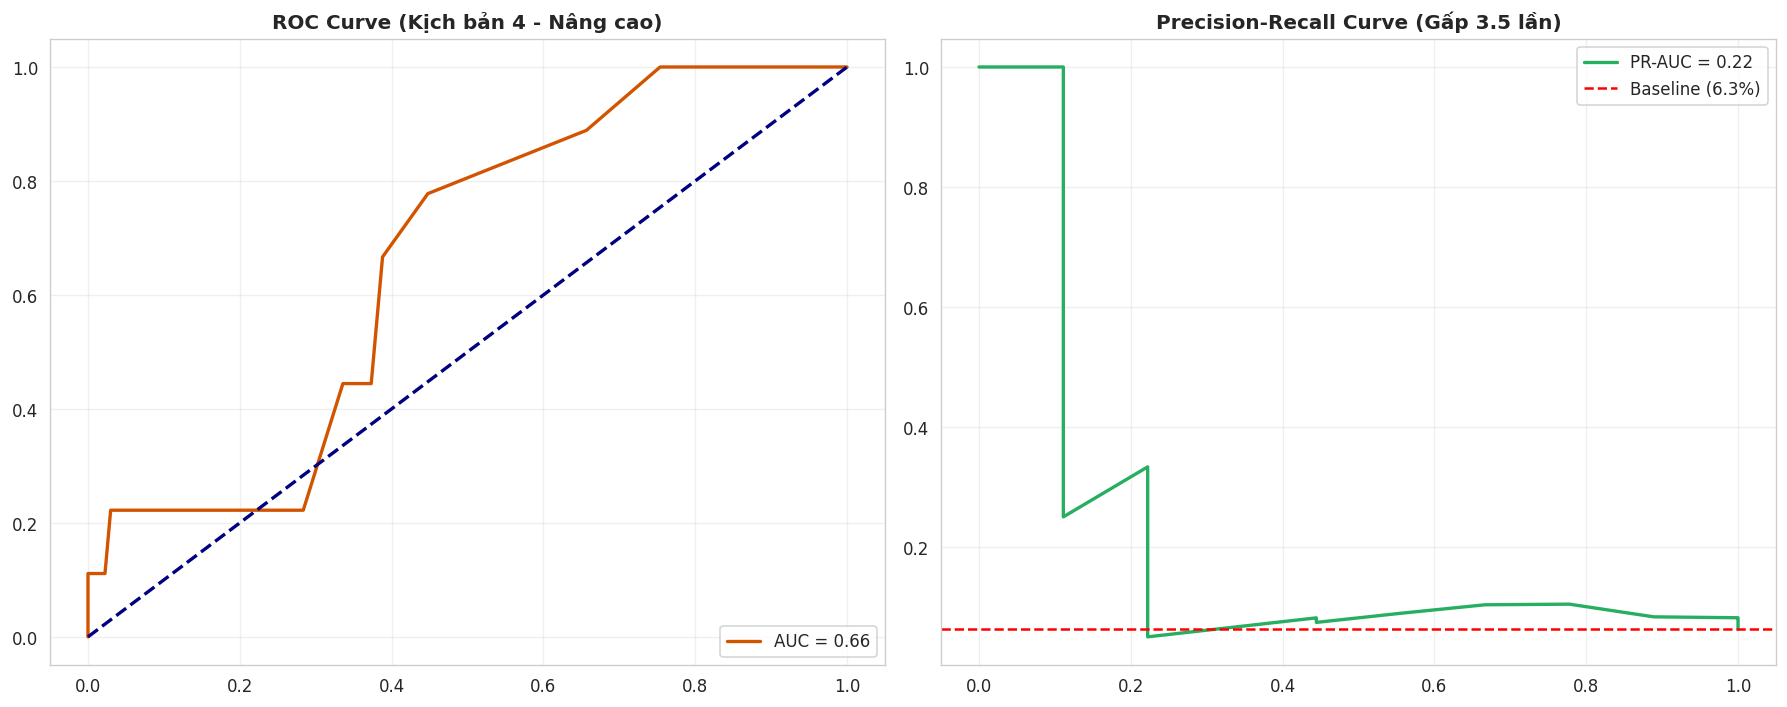

In [104]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 1: THIẾT LẬP THỜI GIAN & CHIA TÁCH DỮ LIỆU
# ==============================================================================
# 1. Chuẩn bị dữ liệu gốc
trans = orders.merge(customers, on='customer_id')
trans = trans.merge(payments, on='order_id')
trans = trans[trans['order_status'] == 'delivered']
trans['order_purchase_timestamp'] = pd.to_datetime(trans['order_purchase_timestamp'])

# Chuẩn hóa tên cột
trans_full = trans.rename(columns={
    'order_purchase_timestamp': 'order_date',
    'payment_value': 'order_value'
})
trans_full = trans_full[['customer_unique_id', 'order_date', 'order_value', 'order_id', 'customer_state']]
trans_full = trans_full[trans_full['order_value'] > 0]

# 2. Thiết lập mốc thời gian
CUTOFF  = pd.Timestamp('2017-12-31')
H_START = CUTOFF + pd.Timedelta(days=1)
H_END   = H_START + pd.DateOffset(months=6)

print(f"--- THIẾT LẬP ---")
print(f"Cutoff Date: {CUTOFF}")
print(f"Holdout End: {H_END}")

# 3. Tạo tập Train Transaction (Dữ liệu quá khứ dùng để tính features)
train_tx = trans_full[trans_full['order_date'] <= CUTOFF].copy()

# ==============================================================================
# BƯỚC 2: TẠO RFM & LỌC NHÓM LẶP LẠI (SUBSET)
# ==============================================================================
rfm_cal_holdout = calibration_and_holdout_data(
    trans_full,
    'customer_unique_id',
    'order_date',
    freq='D',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    monetary_value_col='order_value'
)

# Lọc nhóm khách hàng lặp lại (Frequency > 0)
subset_ml = rfm_cal_holdout[rfm_cal_holdout['frequency_cal'] > 0].copy()
subset_ml = subset_ml[subset_ml['monetary_value_cal'] > 0]

# print(f"Số khách hàng lặp lại (Subset): {len(subset_ml)}")


subset_ml = subset_ml.rename(columns={
    'frequency_cal': 'frequency',
    'recency_cal': 'recency',
    'T_cal': 'T',
    'monetary_value_cal': 'monetary_value'
})

# ==============================================================================
# BƯỚC 3: TẠO FEATURES MỞ RỘNG
# ==============================================================================

valid_order_ids = train_tx['order_id'].unique()

# Lọc chỉ lấy dữ liệu quá khứ
reviews_filtered = reviews[reviews['order_id'].isin(valid_order_ids)]
items_filtered = items[items['order_id'].isin(valid_order_ids)]

# Aggregate Features
agg_base = train_tx[['order_id', 'customer_unique_id', 'customer_state']].copy()

feat_aggs = (
    agg_base
    .merge(payments[['order_id','payment_value']], on='order_id', how='left')
    .merge(reviews_filtered[['order_id','review_score']], on='order_id', how='left')
    .merge(items_filtered[['order_id','product_id']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('payment_value','sum'),
        payment_value_mean  = ('payment_value','mean'),
        review_score_mean   = ('review_score','mean'),
        num_unique_products = ('product_id', pd.Series.nunique),

        state_mode          = ('customer_state', lambda x: x.mode()[0] if len(x.mode())>0 else np.nan)
    ).reset_index()
)

# Merge vào subset_ml

if 'customer_unique_id' in subset_ml.columns:
    subset_ml = subset_ml.set_index('customer_unique_id')

subset_ml = subset_ml.merge(feat_aggs, left_index=True, right_on='customer_unique_id', how='left')
subset_ml = subset_ml.set_index('customer_unique_id')

# ==============================================================================
# BƯỚC 4: TẠO & CẤU HÌNH PREPROCESSOR (PIPELINE)
# ==============================================================================
# Xác định danh sách Features
numeric_features = [
    'frequency', 'recency', 'T', 'monetary_value',
    'payment_value_sum', 'payment_value_mean',
    'review_score_mean', 'num_unique_products'
]

categorical_features = ['state_mode']

print(f"--> Features số: {len(numeric_features)}")
print(f"--> Features phân loại: {categorical_features}")

# 1. Pipeline cho numeric
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline cho categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. ColumnTransformer tổng hợp
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    verbose_feature_names_out=False
)

# ==============================================================================
# BƯỚC 5: CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN
# ==============================================================================
# Target
subset_ml['target_spend'] = subset_ml['frequency_holdout'] * subset_ml['monetary_value_holdout']
subset_ml['is_buy'] = (subset_ml['target_spend'] > 0).astype(int)
subset_ml['log_spend'] = np.log1p(subset_ml['target_spend'])

X = subset_ml
y_class = subset_ml['is_buy']
y_reg = subset_ml['log_spend']

# Split Train/Test
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42, stratify=y_class
)

# ==============================================================================
# BƯỚC 6: HUẤN LUYỆN MÔ HÌNH (TWO-STAGE VỚI PREPROCESSOR)
# ==============================================================================

# --- Giai đoạn 1: Classifier ---
clf = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')

# Pipeline: Preprocessor -> SMOTE -> Classifier

clf_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', clf)
])

# Calibrated Classifier
calibrated_clf = CalibratedClassifierCV(clf_pipe, method='isotonic', cv=3)
calibrated_clf.fit(X_train, y_train_cls)

# Dự báo xác suất
prob_buy_test = calibrated_clf.predict_proba(X_test)[:, 1]

# Đánh giá Sơ bộ Giai đoạn 1
roc_auc = roc_auc_score(y_test_cls, prob_buy_test)
pr_auc = average_precision_score(y_test_cls, prob_buy_test)
baseline_pr = y_test_cls.mean()
print(f"1. CLASSIFIER RESULTS:")
print(f"   - ROC AUC: {roc_auc:.4f}")
print(f"   - PR AUC:  {pr_auc:.4f} (Baseline: {baseline_pr:.4f})")

# --- Giai đoạn 2: Regressor ---
mask_buy = y_train_cls == 1
if mask_buy.sum() > 0:
    reg = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

    # Pipeline: Preprocessor -> Regressor
    reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', reg)
    ])

    reg_pipe.fit(X_train[mask_buy], y_train_reg[mask_buy])

    # Dự báo doanh thu
    pred_log = reg_pipe.predict(X_test)
    pred_val = np.expm1(pred_log)
    final_pred = prob_buy_test * pred_val
else:
    final_pred = np.zeros(len(X_test))

# ==============================================================================
# BƯỚC 7: ĐÁNH GIÁ & VẼ BIỂU ĐỒ
# ==============================================================================
y_true_val = np.expm1(y_test_reg)
mae = mean_absolute_error(y_true_val, final_pred)
rmse = np.sqrt(mean_squared_error(y_true_val, final_pred))
r2 = r2_score(y_true_val, final_pred)

print(f"\n2. FINAL PREDICTION RESULTS (CLV):")
print(f"   - MAE:  {mae:.2f}")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - R2:   {r2:.4f}")

# Vẽ biểu đồ ROC/PR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC
fpr, tpr, _ = roc_curve(y_test_cls, prob_buy_test)
ax1.plot(fpr, tpr, color='#d35400', lw=2, label=f'AUC = {roc_auc:.2f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('ROC Curve (Kịch bản 4 - Nâng cao)', fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# PR
precision, recall, _ = precision_recall_curve(y_test_cls, prob_buy_test)
ax2.plot(recall, precision, color='#27ae60', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
ax2.axhline(y=baseline_pr, color='red', linestyle='--', label=f'Baseline ({baseline_pr:.1%})')
ax2.set_title(f'Precision-Recall Curve (Gấp {pr_auc/baseline_pr:.1f} lần)', fontweight='bold')
ax2.legend(loc="upper right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Chạy thử ML với đầu vào của BG/NBD


1. KHỞI TẠO DỮ LIỆU (ĐÃ LỌC NGÀY & SỬA TÊN CỘT)
Tổng số giao dịch hợp lệ: 96211
Cutoff Date: 2017-12-31 00:00:00
Holdout End: 2018-06-30 00:00:00

2. PHÂN TÍCH GIÁ TRỊ KINH TẾ (GIAI ĐOẠN CALIBRATION)
- Tổng số khách hàng: 42,066 (Khớp số liệu báo cáo)
- Nhóm Lặp lại: 1,169 người (2.78%)
- Đóng góp doanh thu: 5.12%
- ARPU Khách vãng lai: 160 VND
- ARPU Khách lặp lại:  302 VND
=> KẾT LUẬN: Khách lặp lại chi tiêu GẤP 1.9 LẦN so với khách vãng lai.

3. HUẤN LUYỆN BTYD & TẠO BIẾN 2 GIAI ĐOẠN
Số khách hàng lặp lại đưa vào ML (Subset Technical): 709

4. HUẤN LUYỆN MÔ HÌNH ML & ĐÁNH GIÁ
1. CLASSIFIER RESULTS:
   - ROC AUC: 0.6059
   - PR AUC:  0.1507 (Baseline: 0.0563)
   => Gấp 2.7 lần ngẫu nhiên.

>> KẾT QUẢ DỰ BÁO CLV (FINAL):
   - MAE:  14.03
   - RMSE: 29.10
   - R2:   -0.0946


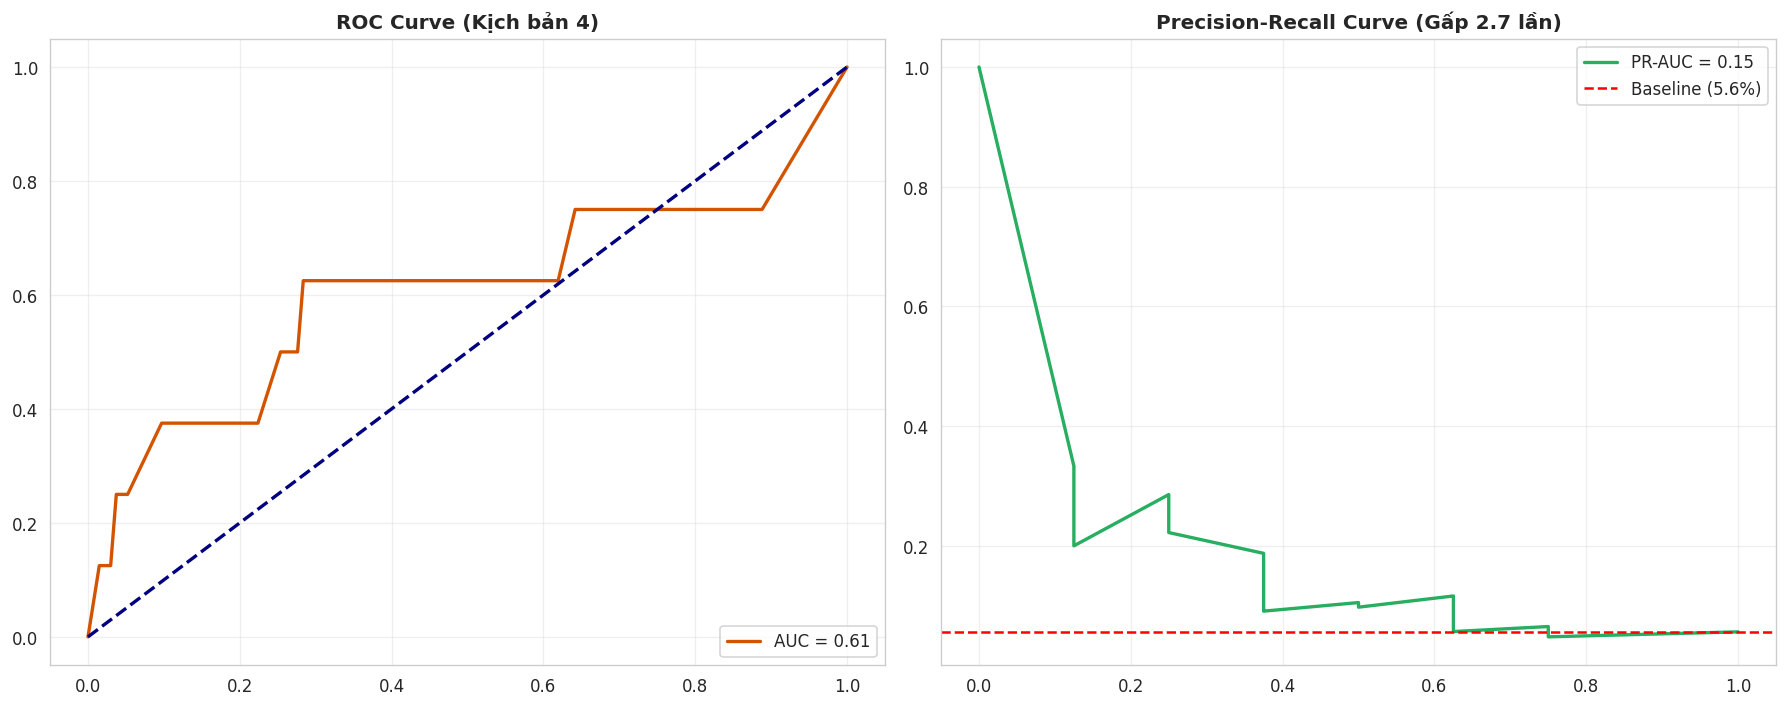

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# ==============================================================================
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU & THIẾT LẬP THỜI GIAN
# ==============================================================================
print("\n" + "="*60)
print("1. KHỞI TẠO DỮ LIỆU (ĐÃ LỌC NGÀY & SỬA TÊN CỘT)")
print("="*60)

# 1. Xử lý bảng Orders
orders_clean = orders[orders['order_status'] == 'delivered'].copy()
orders_clean['order_purchase_timestamp'] = pd.to_datetime(orders_clean['order_purchase_timestamp'], errors='coerce')

# 2. Tính giá trị đơn hàng (Price + Freight) từ bảng Items
items_clean = items.copy()
items_clean['order_value'] = items_clean['price'] + items_clean['freight_value']
order_val = items_clean.groupby('order_id', as_index=False)['order_value'].sum()

# 3. Merge bảng giao dịch
trans = (
    orders_clean[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
)

# 4. Lọc dữ liệu & Thời gian
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')
trans = trans.dropna(subset=['order_date', 'order_value', 'customer_unique_id'])
trans = trans[trans['order_value'] > 0]

# Chỉ lấy dữ liệu từ 01/01/2017 để khớp số liệu 42,066
trans = trans[trans['order_date'] >= '2017-01-01']

# Thiết lập mốc thời gian Cố định
CUTOFF = pd.Timestamp('2017-12-31')
H_END  = pd.Timestamp('2018-06-30')

print(f"Tổng số giao dịch hợp lệ: {len(trans)}")
print(f"Cutoff Date: {CUTOFF}")
print(f"Holdout End: {H_END}")

# Tạo tập Train Transaction (Dữ liệu quá khứ để tính features)
train_tx = trans[trans['order_date'] <= CUTOFF].copy()

# ==============================================================================
# BƯỚC 2: PHÂN TÍCH GIÁ TRỊ KINH TẾ (INSIGHT)
# ==============================================================================
print("\n" + "="*60)
print("2. PHÂN TÍCH GIÁ TRỊ KINH TẾ (GIAI ĐOẠN CALIBRATION)")
print("="*60)

cust_stats = train_tx.groupby('customer_unique_id').agg({
    'order_id': 'nunique',
    'order_value': 'sum'
}).reset_index()

pop_total = len(cust_stats)
repeat_group = cust_stats[cust_stats['order_id'] > 1]
onetime_group = cust_stats[cust_stats['order_id'] == 1]

pop_repeat = len(repeat_group)
rev_repeat = repeat_group['order_value'].sum()
rev_total = cust_stats['order_value'].sum()

share_pop_repeat = (pop_repeat / pop_total) * 100
share_rev_repeat = (rev_repeat / rev_total) * 100

arpu_onetime = onetime_group['order_value'].mean()
arpu_repeat = repeat_group['order_value'].mean()
lift_arpu = arpu_repeat / arpu_onetime

print(f"- Tổng số khách hàng: {pop_total:,} (Khớp số liệu báo cáo)")
print(f"- Nhóm Lặp lại: {pop_repeat:,} người ({share_pop_repeat:.2f}%)")
print(f"- Đóng góp doanh thu: {share_rev_repeat:.2f}%")
print(f"- ARPU Khách vãng lai: {arpu_onetime:,.0f} VND")
print(f"- ARPU Khách lặp lại:  {arpu_repeat:,.0f} VND")
print(f"=> KẾT LUẬN: Khách lặp lại chi tiêu GẤP {lift_arpu:.1f} LẦN so với khách vãng lai.")

# ==============================================================================
# BƯỚC 3: TẠO BIẾN XÁC SUẤT (LOGIC: HỌC TỔNG THỂ - ÁP DỤNG CỤC BỘ)
# ==============================================================================
print("\n" + "="*60)
print("3. HUẤN LUYỆN BTYD & TẠO BIẾN 2 GIAI ĐOẠN")
print("="*60)

# 1. Tạo RFM Matrix cho TOÀN BỘ khách hàng
rfm_full = calibration_and_holdout_data(
    trans,
    'customer_unique_id',
    'order_date',
    freq='D',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    monetary_value_col='order_value'
)

# 2. Huấn luyện BG/NBD trên TOÀN BỘ dữ liệu (Để học tham số r, alpha, a, b chuẩn nhất)

bgf_full = BetaGeoFitter(penalizer_coef=0.01)
bgf_full.fit(rfm_full['frequency_cal'], rfm_full['recency_cal'], rfm_full['T_cal'])

# 3. Huấn luyện Gamma-Gamma (Chỉ trên tập hợp lệ của toàn bộ)

gg_data_full = rfm_full[(rfm_full['frequency_cal'] > 0) & (rfm_full['monetary_value_cal'] > 0)]
ggf_full = GammaGammaFitter(penalizer_coef=0.01)
ggf_full.fit(gg_data_full['frequency_cal'], gg_data_full['monetary_value_cal'])

# 4. Lọc ra nhóm SUBSET để chạy ML (Chỉ lấy khách hàng lặp lại)
subset_ml = rfm_full[(rfm_full['frequency_cal'] > 0) & (rfm_full['monetary_value_cal'] > 0)].copy()
print(f"Số khách hàng lặp lại đưa vào ML (Subset Technical): {len(subset_ml)}")

# Đổi tên cột cho gọn
subset_ml = subset_ml.rename(columns={
    'frequency_cal': 'frequency', 'recency_cal': 'recency',
    'T_cal': 'T', 'monetary_value_cal': 'monetary_value'
})

# 5. ÁP DỤNG MÔ HÌNH TOÀN CỤC ĐỂ TÍNH CHỈ SỐ CHO SUBSET

subset_ml['prob_alive'] = bgf_full.conditional_probability_alive(subset_ml['frequency'], subset_ml['recency'], subset_ml['T'])
days_holdout = (H_END - CUTOFF).days
subset_ml['pred_freq'] = bgf_full.predict(days_holdout, subset_ml['frequency'], subset_ml['recency'], subset_ml['T'])
subset_ml['pred_monetary'] = ggf_full.conditional_expected_average_profit(subset_ml['frequency'], subset_ml['monetary_value'])

# ==============================================================================
# BƯỚC 4: FEATURE ENGINEERING (TẠO BIẾN MỞ RỘNG)
# ==============================================================================

valid_order_ids = train_tx['order_id'].unique()

# Lọc bảng
reviews_filtered = reviews[reviews['order_id'].isin(valid_order_ids)]

# Aggregate Features
agg_base = train_tx[['order_id', 'customer_unique_id', 'customer_state', 'order_value']].copy()

feat_aggs = (
    agg_base
    .merge(reviews_filtered[['order_id', 'review_score']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('order_value', 'sum'),
        payment_value_mean  = ('order_value', 'mean'),
        review_score_mean   = ('review_score', 'mean'),
        state_mode          = ('customer_state', 'first')
    ).reset_index()
)

# Merge vào subset_ml
subset_ml = subset_ml.merge(feat_aggs, left_index=True, right_on='customer_unique_id', how='left')
subset_ml = subset_ml.set_index('customer_unique_id')
subset_ml = subset_ml.fillna(0)

# ==============================================================================
# BƯỚC 5: HUẤN LUYỆN & ĐÁNH GIÁ (TWO-STAGE XGBOOST)
# ==============================================================================
print("\n" + "="*60)
print("4. HUẤN LUYỆN MÔ HÌNH ML & ĐÁNH GIÁ")
print("="*60)

# 1. Chuẩn bị Target
subset_ml['target_spend'] = subset_ml['frequency_holdout'] * subset_ml['monetary_value_holdout']
subset_ml['is_buy'] = (subset_ml['target_spend'] > 0).astype(int)
subset_ml['log_spend'] = np.log1p(subset_ml['target_spend'])

# 2. Danh sách Features (Bao gồm cả biến xác suất và biến hành vi)
numeric_features = [
    'frequency', 'recency', 'T', 'monetary_value',
    'prob_alive', 'pred_freq', 'pred_monetary',  # <--- Biến lai ghép từ BTYD
    'payment_value_sum', 'payment_value_mean', 'review_score_mean' # <--- Biến mở rộng
]
categorical_features = ['state_mode']

# Pipeline
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X = subset_ml
y_class = subset_ml['is_buy']
y_reg = subset_ml['log_spend']

# Split Train/Test
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(X, y_class, y_reg, test_size=0.2, random_state=42, stratify=y_class)

# 3. Stage 1: Classifier

clf = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')
clf_pipe = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('model', clf)])
calibrated_clf = CalibratedClassifierCV(clf_pipe, method='isotonic', cv=3)
calibrated_clf.fit(X_train, y_train_cls)

prob_buy_test = calibrated_clf.predict_proba(X_test)[:, 1]

# Đánh giá Classifier
roc_auc = roc_auc_score(y_test_cls, prob_buy_test)
pr_auc = average_precision_score(y_test_cls, prob_buy_test)
baseline_pr = y_test_cls.mean()
lift = pr_auc / baseline_pr if baseline_pr > 0 else 0

print(f"1. CLASSIFIER RESULTS:")
print(f"   - ROC AUC: {roc_auc:.4f}")
print(f"   - PR AUC:  {pr_auc:.4f} (Baseline: {baseline_pr:.4f})")
print(f"   => Gấp {lift:.1f} lần ngẫu nhiên.")

# 4. Stage 2: Regressor

mask_buy = y_train_cls == 1
if mask_buy.sum() > 0:
    reg = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    reg_pipe = Pipeline([('preprocessor', preprocessor), ('model', reg)])
    reg_pipe.fit(X_train[mask_buy], y_train_reg[mask_buy])

    pred_log = reg_pipe.predict(X_test)
    pred_val = np.expm1(pred_log)
    final_pred = prob_buy_test * pred_val
else:
    final_pred = np.zeros(len(X_test))

# Đánh giá Final CLV
y_true_val = np.expm1(y_test_reg)
mae = mean_absolute_error(y_true_val, final_pred)
rmse = np.sqrt(mean_squared_error(y_true_val, final_pred))
r2 = r2_score(y_true_val, final_pred)

print(f"\n>> KẾT QUẢ DỰ BÁO CLV (FINAL):")
print(f"   - MAE:  {mae:.2f}")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - R2:   {r2:.4f}")

# ==============================================================================
# BƯỚC 6: VẼ BIỂU ĐỒ ROC/PR
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC
fpr, tpr, _ = roc_curve(y_test_cls, prob_buy_test)
ax1.plot(fpr, tpr, color='#d35400', lw=2, label=f'AUC = {roc_auc:.2f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('ROC Curve (Kịch bản 4)', fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# PR
precision, recall, _ = precision_recall_curve(y_test_cls, prob_buy_test)
ax2.plot(recall, precision, color='#27ae60', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
ax2.axhline(y=baseline_pr, color='red', linestyle='--', label=f'Baseline ({baseline_pr:.1%})')
ax2.set_title(f'Precision-Recall Curve (Gấp {lift:.1f} lần)', fontweight='bold')
ax2.legend(loc="upper right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Chạy lại tập trans

In [106]:
# Giữ đơn đã giao thành công (order_status là delivered)
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

# Tính giá trị đơn hàng = price + freight_value
items['order_value'] = items['price'] + items['freight_value']
order_val = items.groupby('order_id', as_index=False)['order_value'].sum()

# Merge bảng giao dịch
trans = (
    orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
#  .dropna()
#  .drop_duplicates()
)
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')

# Chỉ giữ lại dữ liệu từ 01/01/2017 trở đi
trans = trans[trans['order_date'] >= '2017-01-01']
print("Tổng số giao dịch:", len(trans))
trans.head(3)


Tổng số giao dịch: 96211


,order_id,customer_unique_id,order_date,order_value,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:00,38.71,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:00,141.46,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:00,179.12,GO



BÁO CÁO PHÂN TÍCH GIÁ TRỊ KHÁCH HÀNG (GIAI ĐOẠN 01/01/2017 - 31/12/2017)
1. THỐNG KÊ DÂN SỐ (GIAI ĐOẠN 2017):
   - Tổng số khách hàng: 42,066 (Kỳ vọng: 42,066)
   - Khách hàng Repeat:  1,169 (Chiếm 2.78%)
   - Khách hàng One-time: 40,897 (Chiếm 97.22%)
----------------------------------------
2. THỐNG KÊ DOANH THU (GMV):
   - Tổng GMV: 6,911,611 VND
   - GMV từ nhóm Repeat: 353,572 VND (Đóng góp 5.12%)
----------------------------------------
3. SO SÁNH HIỆU QUẢ (ARPU):
   - ARPU Khách vãng lai: 160 VND
   - ARPU Khách trung thành: 302 VND
   => KẾT LUẬN: Nhóm khách hàng lặp lại chi tiêu cao hơn 88.62% so với nhóm còn lại.


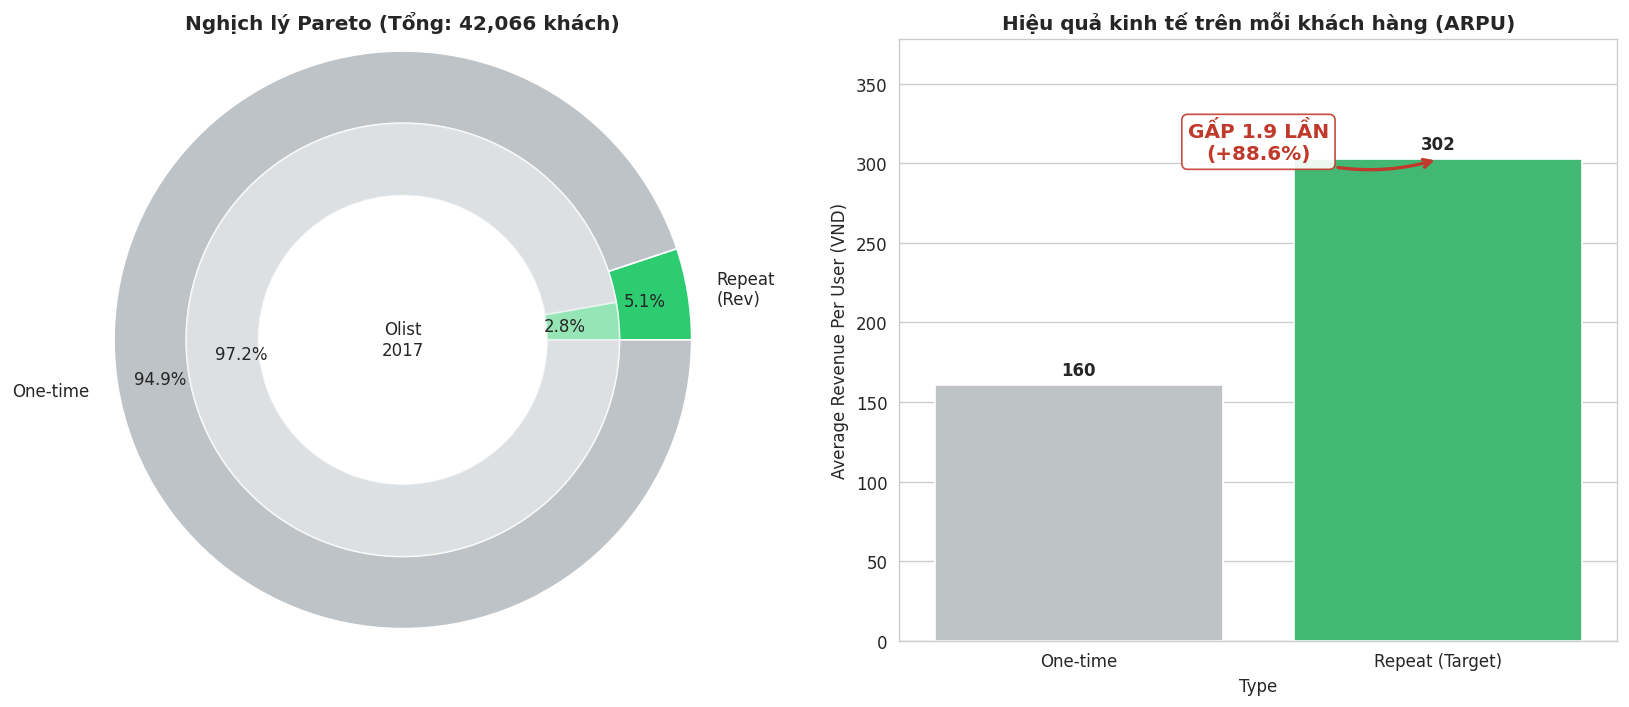

In [107]:
# ==============================================================================
# BƯỚC 3.5: PHÂN TÍCH GIÁ TRỊ KINH TẾ
# ==============================================================================
print("\n" + "="*60)
print("BÁO CÁO PHÂN TÍCH GIÁ TRỊ KHÁCH HÀNG (GIAI ĐOẠN 01/01/2017 - 31/12/2017)")
print("="*60)

# --- 1. CHUẨN BỊ DỮ LIỆU TÍNH TOÁN ---
# Khởi tạo ngày bắt đầu
start_date = pd.to_datetime('2017-01-01')

# Lọc dữ liệu
analyze_df = trans[(trans['order_date'] >= start_date) & (trans['order_date'] <= CUTOFF)].copy()

# Xác định tên cột
val_col = 'order_value'
id_col = 'customer_unique_id'

# --- 2. TÍNH TOÁN LẠI CÁC NHÓM KHÁCH HÀNG ---
# Gom nhóm để tính tần suất mua của từng khách
cust_stats = analyze_df.groupby(id_col).agg({
    'order_id': 'nunique',      # Số đơn hàng
    val_col: 'sum'              # Tổng chi tiêu
}).reset_index()

# Định nghĩa lại nhóm Repeat và One-time
repeat_group = cust_stats[cust_stats['order_id'] > 1]
onetime_group = cust_stats[cust_stats['order_id'] == 1]

# --- 3. TÍNH CÁC CHỈ SỐ THỐNG KÊ ---
# a. Population
pop_total = len(cust_stats)
pop_repeat = len(repeat_group)
pop_onetime = len(onetime_group)
share_pop_repeat = (pop_repeat / pop_total) * 100 if pop_total > 0 else 0

# b. Revenue
rev_total = cust_stats[val_col].sum()
rev_repeat = repeat_group[val_col].sum()
rev_onetime = onetime_group[val_col].sum()
share_rev_repeat = (rev_repeat / rev_total) * 100 if rev_total > 0 else 0

# c. ARPU
arpu_repeat = rev_repeat / pop_repeat if pop_repeat > 0 else 0
arpu_onetime = rev_onetime / pop_onetime if pop_onetime > 0 else 0
diff_percent = ((arpu_repeat - arpu_onetime) / arpu_onetime) * 100 if arpu_onetime > 0 else 0

# --- 4. IN KẾT QUẢ  ---
print(f"1. THỐNG KÊ DÂN SỐ (GIAI ĐOẠN 2017):")
print(f"   - Tổng số khách hàng: {pop_total:,} (Kỳ vọng: 42,066)")
print(f"   - Khách hàng Repeat:  {pop_repeat:,} (Chiếm {share_pop_repeat:.2f}%)")
print(f"   - Khách hàng One-time: {pop_onetime:,} (Chiếm {100-share_pop_repeat:.2f}%)")
print("-" * 40)
print(f"2. THỐNG KÊ DOANH THU (GMV):")
print(f"   - Tổng GMV: {rev_total:,.0f} VND")
print(f"   - GMV từ nhóm Repeat: {rev_repeat:,.0f} VND (Đóng góp {share_rev_repeat:.2f}%)")
print("-" * 40)
print(f"3. SO SÁNH HIỆU QUẢ (ARPU):")
print(f"   - ARPU Khách vãng lai: {arpu_onetime:,.0f} VND")
print(f"   - ARPU Khách trung thành: {arpu_repeat:,.0f} VND")
print(f"   => KẾT LUẬN: Nhóm khách hàng lặp lại chi tiêu cao hơn {diff_percent:.2f}% so với nhóm còn lại.")
print("="*60)

# --- 5. VẼ BIỂU ĐỒ TRỰC QUAN HÓA ---
sns.set_style("whitegrid")
fig = plt.figure(figsize=(14, 6))

# Biểu đồ 1: Nested Pie Chart
ax1 = plt.subplot(1, 2, 1)
wedges_rev, texts_rev, autotexts_rev = ax1.pie(
    [share_rev_repeat, 100-share_rev_repeat],
    labels=['Repeat\n(Rev)', 'One-time'],
    radius=1.2, colors=['#2ecc71', '#bdc3c7'],
    autopct='%1.1f%%', pctdistance=0.85,
    wedgeprops=dict(width=0.3, edgecolor='w')
)
wedges_pop, texts_pop, autotexts_pop = ax1.pie(
    [share_pop_repeat, 100-share_pop_repeat],
    colors=['#2ecc71', '#bdc3c7'], radius=0.9,
    autopct='%1.1f%%', pctdistance=0.75,
    wedgeprops=dict(width=0.3, edgecolor='w', alpha=0.5)
)
ax1.set_title(f'Nghịch lý Pareto (Tổng: {pop_total:,} khách)', fontsize=12, fontweight='bold')
ax1.text(0, 0, 'Olist\n2017', ha='center', va='center', fontsize=10)

# Biểu đồ 2: Bar Chart so sánh ARPU
ax2 = plt.subplot(1, 2, 2)
arpu_data = pd.DataFrame({
    'Type': ['One-time', 'Repeat (Target)'],
    'ARPU': [arpu_onetime, arpu_repeat]
})
bars = sns.barplot(x='Type', y='ARPU', data=arpu_data, palette=['#bdc3c7', '#2ecc71'], ax=ax2)

for p in bars.patches:
    bars.annotate(f'{p.get_height():,.0f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 9),
                  textcoords='offset points', fontweight='bold')

ymax = arpu_repeat * 1.25
ratio = arpu_repeat / arpu_onetime if arpu_onetime > 0 else 0
ax2.annotate(f'GẤP {ratio:.1f} LẦN\n(+{diff_percent:.1f}%)',
             xy=(1, arpu_repeat), xycoords='data',
             xytext=(0.5, arpu_repeat), textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='#c0392b', lw=2),
             color='#c0392b', fontweight='bold', fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#c0392b", alpha=0.9))

ax2.set_title('Hiệu quả kinh tế trên mỗi khách hàng (ARPU)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Revenue Per User (VND)')
ax2.set_ylim(0, ymax)

plt.tight_layout()
plt.show()

## 11.Empirical Retention

     F_bin  n_customers  retention_rate  avg_clv_6m
0   F1_low        10517        0.012836    1.846699
1       F2        10516        0.011316    1.631743
2       F3        10516        0.010841    1.633309
3  F4_high        10517        0.015974    2.917051


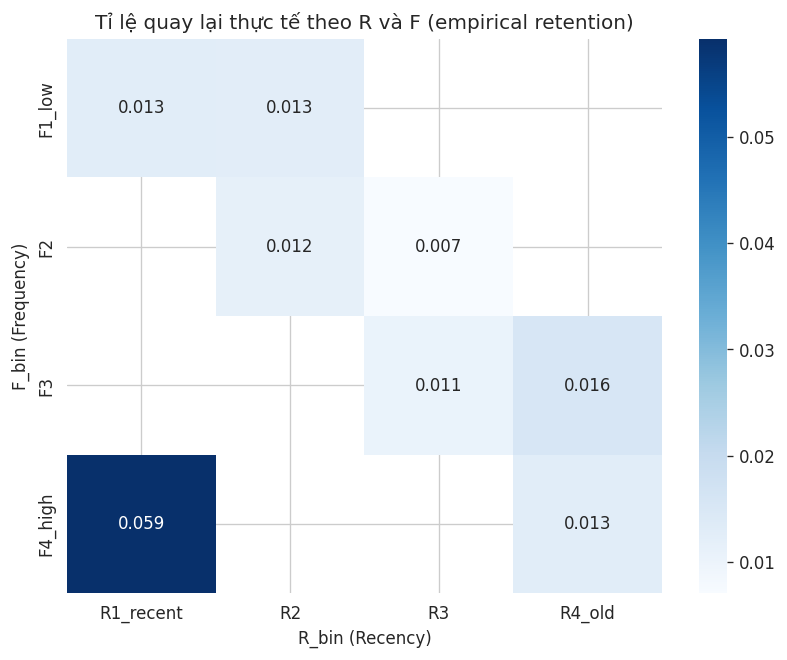

In [108]:
# Flag quay lại
summary_ml['retained_6m'] = (summary_ml['CLV_actual_6m'] > 0).astype(int)

import pandas as pd

# Recency
summary_ml['R_bin'] = pd.qcut(
    summary_ml['recency'].rank(method='first', ascending=False),
    q=4,
    labels=['R1_recent', 'R2', 'R3', 'R4_old']
)

# Frequency
summary_ml['F_bin'] = pd.qcut(
    summary_ml['frequency'].rank(method='first', ascending=True),
    q=4,
    labels=['F1_low', 'F2', 'F3', 'F4_high']
)

# Monetary
summary_ml['M_bin'] = pd.qcut(
    summary_ml['monetary_value'].rank(method='first', ascending=True),
    q=4,
    labels=['M1_low', 'M2', 'M3', 'M4_high']
)
ret_by_F = (
    summary_ml.groupby('F_bin')
    .agg(
        n_customers=('retained_6m', 'size'),
        retention_rate=('retained_6m', 'mean'),
        avg_clv_6m=('CLV_actual_6m', 'mean')
    )
    .reset_index()
)
print(ret_by_F)
import seaborn as sns
import matplotlib.pyplot as plt

ret_matrix = pd.pivot_table(
    summary_ml,
    values='retained_6m',
    index='F_bin',
    columns='R_bin',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(ret_matrix, annot=True, fmt=".3f", cmap="Blues")
plt.title("Tỉ lệ quay lại thực tế theo R và F (empirical retention)")
plt.ylabel("F_bin (Frequency)")
plt.xlabel("R_bin (Recency)")
plt.show()
